# Quantified Sleep: Data wrangling and preprocessing

In [1]:
# Automatically reload external modules (ingesters) on execution
%load_ext autoreload
%autoreload 2

In [2]:
import math
from pathlib import Path

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from matplotlib import pyplot as plt

# Import the ingesters
from sources.ingesters import (
	aware_activities,
	aware_barometer,
	aware_calls,
	aware_heart_rate,
	aware_locations,
	aware_motion,
	aware_weather,
	cbd,
	daily_metrics,
	health_kit,
	melatonin,
	nomie,
	oura,
	rescue_time,
	sitrus,
	way_of_life,
	zero,
)
from sources.utils import restyle_columns

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# Set some important variables for the notebook
DATADIR = Path('../Data/')
RAWDATADIR = DATADIR/'Raw_new/'
FIGSDIR = Path('../Figs/')

LAST_DATE = '2021-01-20' # the final date to consider for the study

This next function `datify` is going to be very useful for "midnight unwrapping" in much of the coming preprocessing code

In [5]:
# Generate summary date (wrapping times before 5AM to the previous day)
from datetime import datetime


def datify(d):
    if d.time() < pd.Timestamp('05:00:00').time():
        return d.date() - pd.Timedelta('1D')
    else:
        return d.date()

## Loading data sources and preprocessing*

*and some feature engineering

Let's quickly start by merging the sleeping location information onto the daily metrics

In [6]:
df_dm = daily_metrics.ingest(RAWDATADIR/'Daily Metrics - Sheet1.tsv')

In [7]:
df_dm.shape

(998, 36)

In [8]:
# Drop future dates that sometimes come along for the ride
df_dm = df_dm[df_dm['daily_date'] < LAST_DATE]

In [9]:
df_dm.shape

(933, 36)

I attach my external record of the locations I slept each night and merge with other daily metrics.

In [10]:
df_locs = pd.read_csv(RAWDATADIR/'Sleep Locations.csv')

In [11]:
df_daily = df_dm.merge(df_locs, how='left', left_on='daily_current_location_(where_', right_on='Location')

In [12]:
df_daily = restyle_columns(df_daily)

Let's engineer some obvious, but likely-useful features relating to datetime.

In [13]:
df_daily['daily_weekday'] = df_daily['daily_date'].dt.weekday
df_daily['daily_month'] = df_daily['daily_date'].dt.month

In [14]:
df_daily['is_weekend'] = df_daily['daily_weekday'].apply(lambda x: 1 if x > 4 else 0)

This one is very bespoke, but should be valuable.

In [ ]:
df_daily['country'].value_counts(dropna=False)

In [16]:
# Fill in some missing data using knowledge-based approach
df_daily.loc[df_daily.daily_date > '2020-03-13', 'country'] = 'XXX'
df_daily.loc[df_daily.daily_date > '2020-03-13', 'location'] = 'Redacted'
df_daily.loc[df_daily.daily_date.between('2020-09-10', '2020-10-20'), 'location'] = 'Other'
df_daily.loc[df_daily.daily_date.between('2020-12-20', '2021-01-01'), 'location'] = 'Other'

In [17]:
# Custom function to infer country and hemisphere from date ranges specific to me
def get_country_and_hem(c, d):
    if not isinstance(c, str):
        if pd.to_datetime('2019-08-01') < d < pd.to_datetime('2020-03-01'):
            return 1
        else:
            return 0
    else:
        return 1 if c == 'NLD' else 0

In [ ]:
# Populate hemisphere column
df_daily['north_hemisphere'] = df_daily.apply(lambda x: get_country_and_hem(x['country'], x['daily_date']), axis=1)

In [19]:
df_daily.north_hemisphere.value_counts(dropna=False)

0    734
1    199
Name: north_hemisphere, dtype: int64

In [20]:
df_daily.is_weekend.value_counts()

0    667
1    266
Name: is_weekend, dtype: int64

Only keep the names of locations when that location occurs more than 10 times

In [22]:
top_locs = df_daily['location'].value_counts()
top_locs = top_locs[top_locs > 10]
top_locs

df_daily['location'] = df_daily['location'].apply(lambda x: x if x in top_locs.index else 'Other')

### Oura

We can define the target feature and the alignment (date) feature

In [23]:
df_oura, df_oura_ready = oura.ingest(RAWDATADIR/'oura_2021-01-24T13-57-39.json')
df_oura.shape, df_oura_ready.shape

((787, 39), (817, 12))

In [24]:
df_oura.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787 entries, 0 to 786
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   oura_awake                      787 non-null    int64              
 1   oura_bedtime_end                787 non-null    object             
 2   oura_bedtime_end_delta          787 non-null    int64              
 3   oura_bedtime_end_utc            787 non-null    datetime64[ns, UTC]
 4   oura_bedtime_start              787 non-null    object             
 5   oura_bedtime_start_delta        787 non-null    int64              
 6   oura_bedtime_start_utc          787 non-null    datetime64[ns, UTC]
 7   oura_breath_average             787 non-null    float64            
 8   oura_deep                       787 non-null    int64              
 9   oura_duration                   787 non-null    int64              
 10  oura_efficienc

In [25]:
# Get rid of the is_longest feature that we don't really care about
df_oura.drop('oura_is_longest', axis=1, inplace=True)

In [26]:
TARGET_COL = 'oura_score'
ALIGN_COL = 'oura_summary_date' # The start of the day (the sleep comes later)

df_oura[[ALIGN_COL, TARGET_COL]].tail(5)

,oura_summary_date,oura_score
782,2021-01-20,62
783,2021-01-21,76
784,2021-01-22,76
785,2021-01-23,66
786,2021-01-24,72


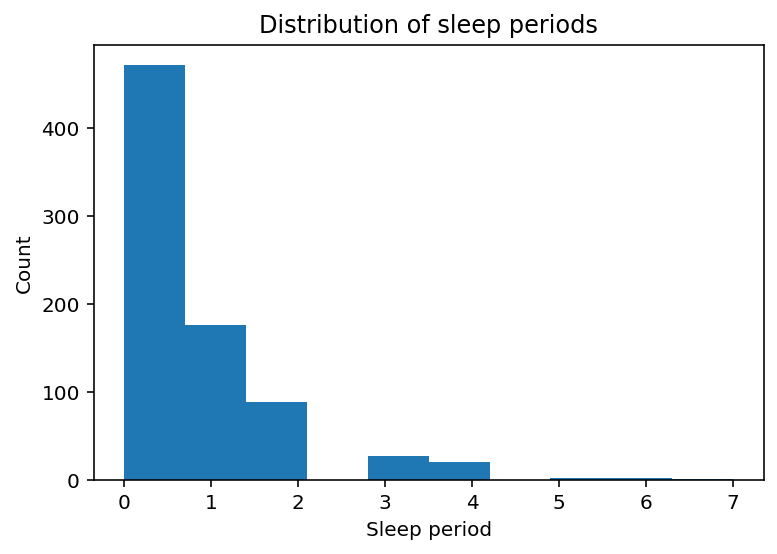

In [27]:
df_oura.oura_period_id.hist(grid=False)
plt.title("Distribution of sleep periods")
plt.xlabel('Sleep period')
plt.ylabel('Count')
plt.savefig(FIGSDIR/'01b_distribution_of_sleep_periods.eps')
plt.show()

Outlier removal with Chauvenet's criterion on a subset of columns

In [28]:
df_oura[['oura_score', 'oura_total', 'oura_efficiency', 'oura_duration']].describe()

,oura_score,oura_total,oura_efficiency,oura_duration
count,787.000000,787.000000,787.000000,787.000000
mean,67.885642,23925.057179,81.373571,29457.484117
std,10.688970,4907.182936,6.811360,5872.564865
min,27.000000,10950.000000,42.000000,12900.000000
25%,61.000000,20595.000000,78.000000,25320.000000
50%,68.000000,24030.000000,82.000000,29280.000000
75%,76.000000,27285.000000,86.000000,33390.000000
max,92.000000,36510.000000,96.000000,54000.000000


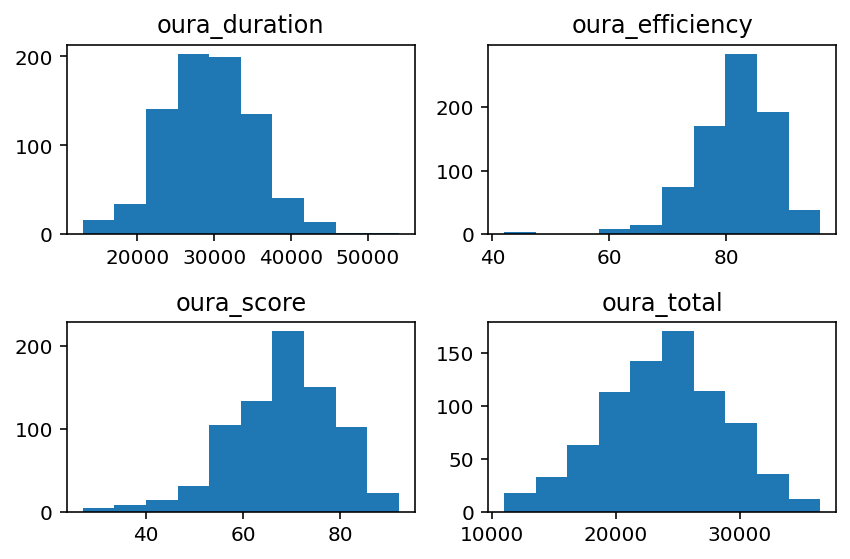

In [29]:
df_oura[['oura_score', 'oura_total', 'oura_efficiency', 'oura_duration']].hist(grid=False)
plt.tight_layout()
plt.savefig(FIGSDIR/'01b_oura_sleep_distributions.eps')
plt.show()

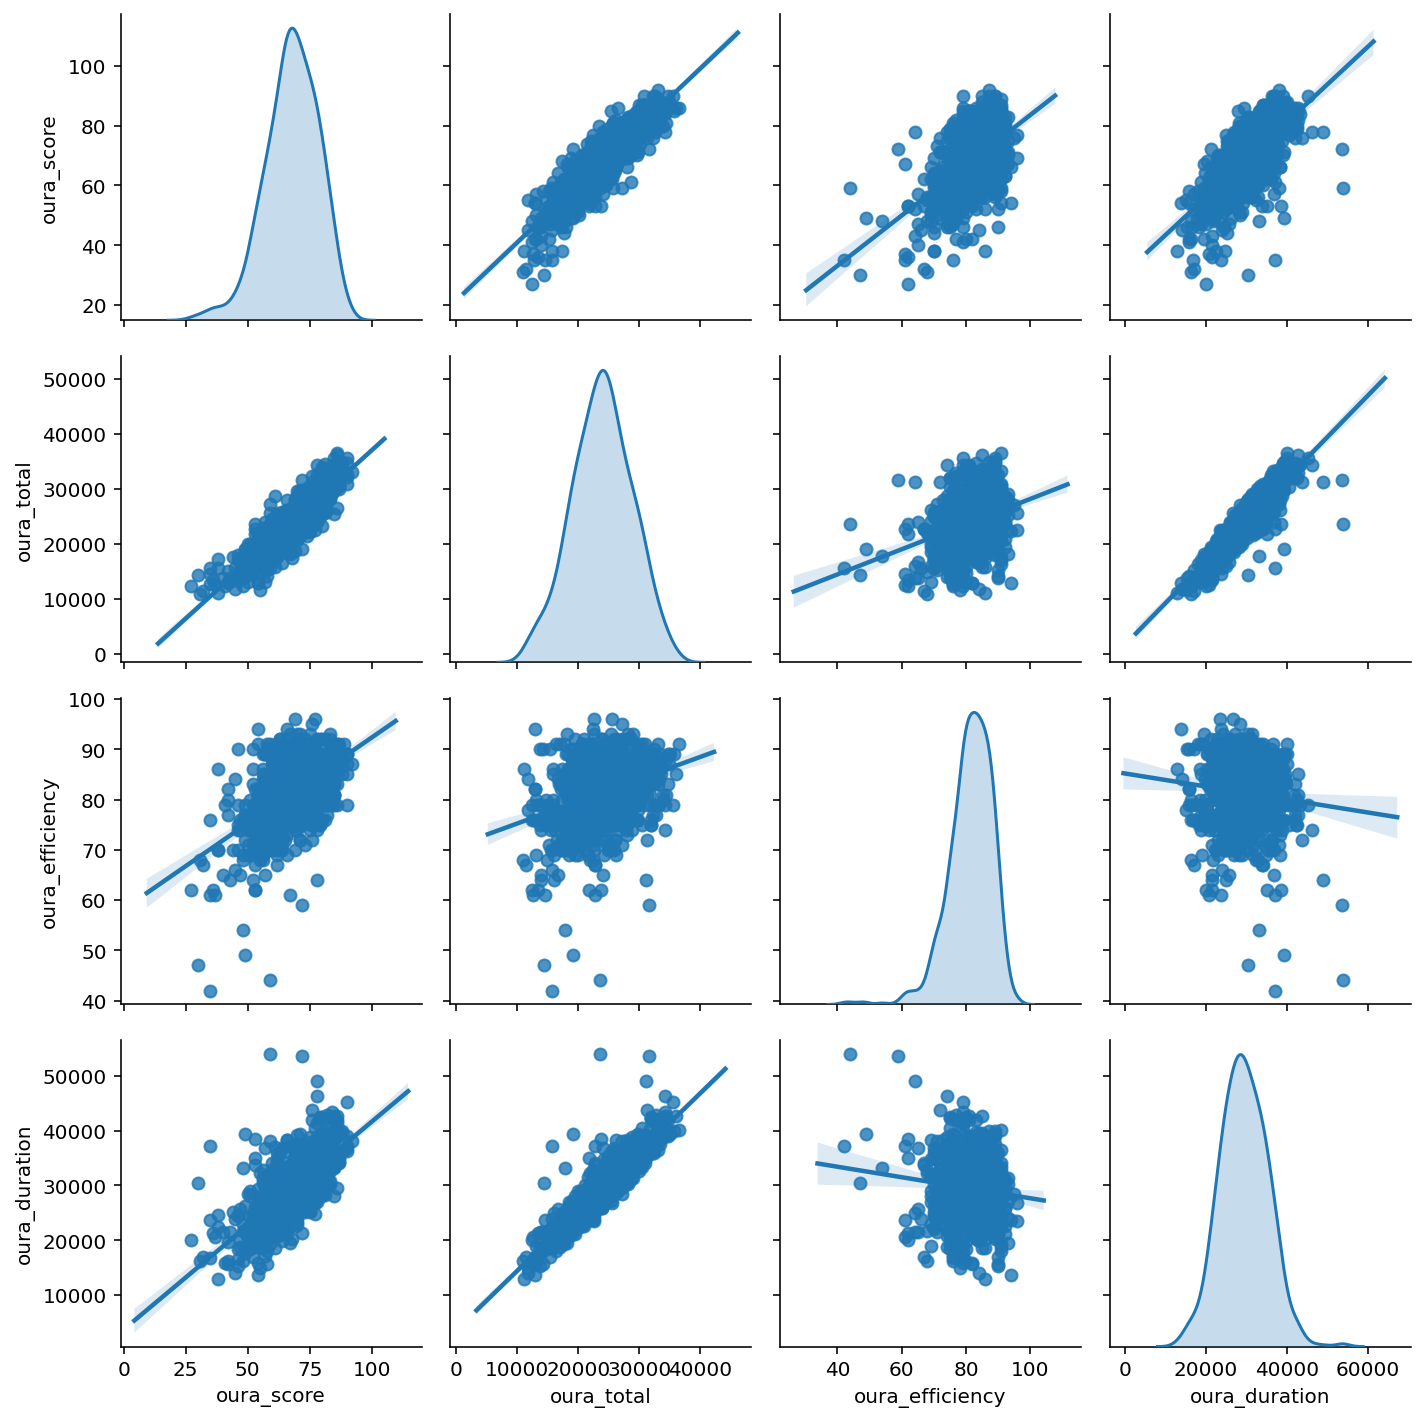

In [30]:
sns.pairplot(df_oura[['oura_score', 'oura_total', 'oura_efficiency', 'oura_duration']], kind='reg', diag_kind='kde')
plt.savefig(FIGSDIR/'01b_oura_sleep_pairplots.png', dpi=500)
plt.tight_layout()
plt.show()

In [31]:
# Check how many nights have obviously-erroneous scores (i.e. sensor errors)
df_oura[
    (df_oura.oura_efficiency < 50) | (df_oura.oura_duration < 14400) | (df_oura.oura_score < 40)
][['oura_summary_date', 'oura_score']]

,oura_summary_date,oura_score
34,2018-12-26,30
42,2019-01-03,49
65,2019-01-26,35
254,2019-08-06,54
264,2019-08-16,31
267,2019-08-20,38
274,2019-08-28,35
304,2019-09-27,32
367,2019-11-29,36
389,2019-12-21,38


In [32]:
def chauvenet(data_table, col):
    # Taken partly from: https://www.astro.rug.nl/software/kapteyn/

    # Compute the mean and standard deviation.
    mean = data_table[col].mean()
    std = data_table[col].std()
    N = len(data_table.index)
    criterion = 1.0/(2*N)

    # Consider the deviation for the data points.
    deviation = abs(data_table[col] - mean)/std

    # Express the upper and lower bounds.
    low = -deviation/math.sqrt(2)
    high = deviation/math.sqrt(2)
    prob = []
    mask = []

    # Pass all rows in the dataset.
    for i in range(0, len(data_table.index)):
        # Determine the probability of observing the point
        prob.append(1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i])))
        # And mark as an outlier when the probability is below our criterion.
        mask.append(prob[i] < criterion)
    data_table[col + '_outlier'] = mask
    return data_table

for col in ['oura_score', 'oura_total', 'oura_efficiency', 'oura_duration']:
    chauvenet(df_oura, col)
    
outlier_cols = [c for c in df_oura.columns if '_outlier' in c]
df_oura.loc[df_oura[outlier_cols].sum(axis=1) == 1, ['oura_summary_date', 'oura_score', *outlier_cols]]

,oura_summary_date,oura_score,oura_score_outlier,oura_total_outlier,oura_efficiency_outlier,oura_duration_outlier
42,2019-01-03,49,False,False,True,False
65,2019-01-26,35,False,False,True,False
264,2019-08-16,31,True,False,False,False
286,2019-09-09,48,False,False,True,False
401,2020-01-03,27,True,False,False,False
570,2020-06-20,72,False,False,False,True


In [33]:
# Drop outliers and remove outlier columns
df_oura = df_oura.loc[df_oura[outlier_cols].sum(axis=1) == 0].drop(outlier_cols, axis=1)
df_oura.shape

(779, 38)

In [34]:
# Now we want to include Oura's "readiness" features too

# Aggregate over the readiness scores with the same date (multiple periods)
df_oura_ready = df_oura_ready.groupby('oura_ready_summary_date').mean().reset_index()
# Drop the ready period that's now redundnat
df_oura_ready.drop('oura_ready_period_id', axis=1, inplace=True)

# Merge onto the oura df using a left join on the sleep summary date
df_oura = df_oura.merge(df_oura_ready, how='left', left_on='oura_summary_date', right_on='oura_ready_summary_date')
df_oura.shape

(779, 49)

In [35]:
print(df_oura['oura_ready_rest_mode_state'].describe())
df_oura.drop('oura_ready_rest_mode_state', axis=1, inplace=True)

count    93.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: oura_ready_rest_mode_state, dtype: float64


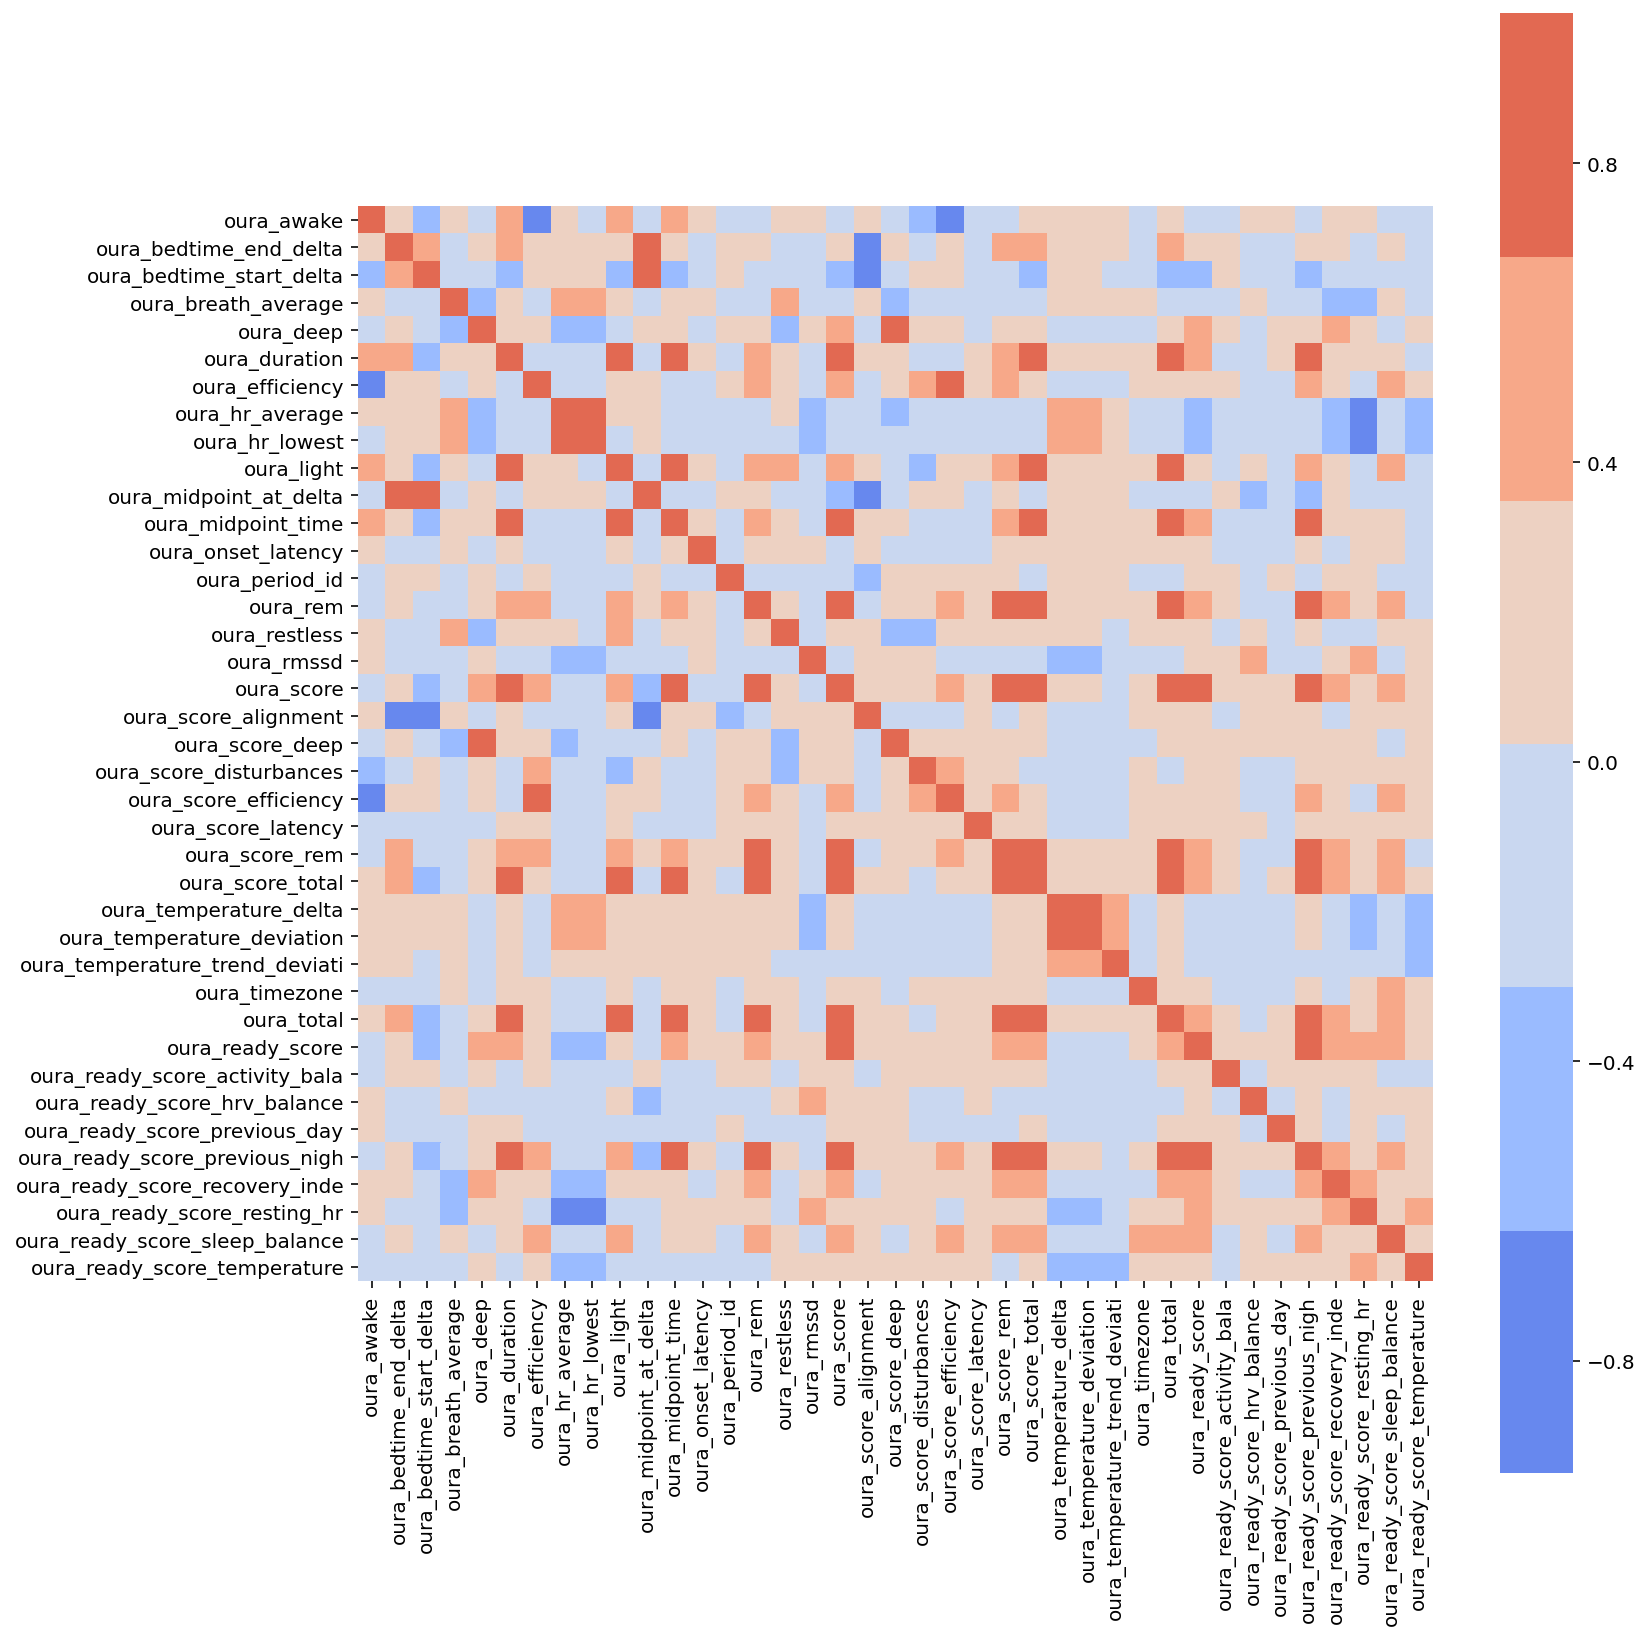

In [36]:
# Oura (sleep + readiness) feature correlation analysis

fig, ax = plt.subplots(1, 1, figsize=(12,12))
corr = df_oura[[c for c in df_oura.columns if 'oura_' in c]].corr()
sns.heatmap(corr, square=True, cmap=sns.color_palette("coolwarm"), ax=ax)
plt.tight_layout()
plt.savefig(FIGSDIR/'01b_oura_feature_correlation_matrix.eps')
plt.show()

In [37]:
# We fit a regression on the Oura features (columns) to find most-predictive (same-day)

from sklearn.linear_model import LinearRegression

X = df_oura[[c for c in df_oura.columns if 'oura_' in c]].select_dtypes(np.number).dropna()
y = X[TARGET_COL]
X.drop(TARGET_COL, axis=1, inplace=True)

lr = LinearRegression(normalize=True)
lr.fit(X, y)
print('R2:', lr.score(X, y))
betas = pd.DataFrame({'feature': X.columns, 'coef': lr.coef_, 'abs': np.abs(lr.coef_)})
betas.sort_values('abs', ascending=False)

R2: 0.9990384288669415


,feature,coef,abs
0,oura_awake,6.788984e+08,6.788984e+08
5,oura_duration,-4.151285e+08,4.151285e+08
9,oura_light,3.826617e+08,3.826617e+08
4,oura_deep,3.826617e+08,3.826617e+08
14,oura_rem,3.826617e+08,3.826617e+08
28,oura_total,2.962367e+08,2.962367e+08
1,oura_bedtime_end_delta,-2.637699e+08,2.637699e+08
11,oura_midpoint_time,-1.430450e+08,1.430450e+08
10,oura_midpoint_at_delta,1.430450e+08,1.430450e+08
2,oura_bedtime_start_delta,1.207249e+08,1.207249e+08


R2 for lag 1: 0.20644273290603943


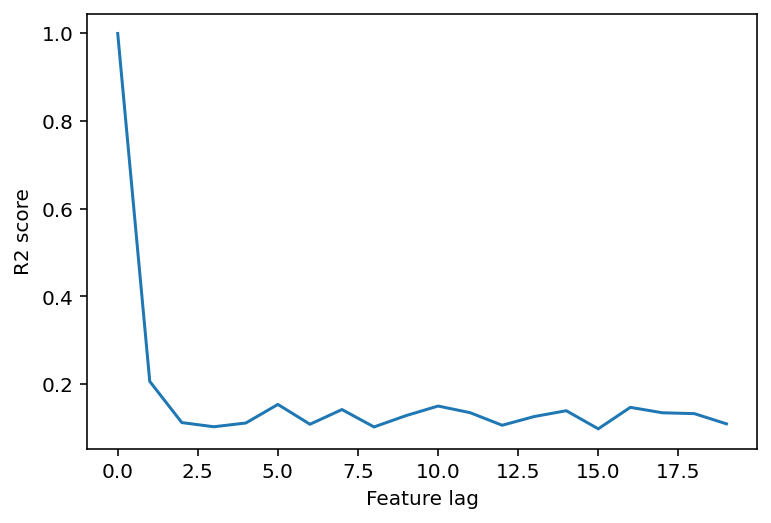

,feature,coef,abs
0,oura_awake,-4.182632e+10,4.182632e+10
5,oura_duration,2.556407e+10,2.556407e+10
4,oura_deep,-2.359375e+10,2.359375e+10
9,oura_light,-2.359375e+10,2.359375e+10
14,oura_rem,-2.359375e+10,2.359375e+10
28,oura_total,-1.823257e+10,1.823257e+10
1,oura_bedtime_end_delta,1.626226e+10,1.626226e+10
10,oura_midpoint_at_delta,-8.820177e+09,8.820177e+09
11,oura_midpoint_time,8.820177e+09,8.820177e+09
2,oura_bedtime_start_delta,-7.442081e+09,7.442081e+09


In [38]:
# Repeat the regression analysis, but use lagging features

feat_cols = [c for c in df_oura.columns if 'oura_' in c]

r2s = []
LAGS = 20
for lag in range(0, LAGS):
    X = df_oura[feat_cols].select_dtypes(np.number).dropna()
    y = X[TARGET_COL].values[lag:]
    X.drop(TARGET_COL, axis=1, inplace=True)
    X = X.shift(lag).dropna()

    lr = LinearRegression(normalize=True).fit(X, y)
    r2s.append(lr.score(X, y))
    betas = pd.DataFrame({'feature': X.columns, 'coef': lr.coef_, 'abs': np.abs(lr.coef_)}).sort_values('abs', ascending=False)
    
    if lag == 1:
        saved_betas = betas
        print("R2 for lag 1:", r2s[-1])
    
plt.plot(np.arange(0, LAGS), r2s)
plt.xlabel('Feature lag')
plt.ylabel('R2 score')
plt.savefig(FIGSDIR/'01b_regression_scores_lagged.eps')
plt.show()

saved_betas

We add a "lagging" version of this for the previous day's data

In [39]:
# Now we make new columns that shifts the records by one (i.e. yesterday's data)
# Note that we deliberately use "sleep_yesterday" prefix instead of "oura_" prefix so that we can drop oura features later, but keep "lagged" sleep features.

LAG_COLS = [c for c in df_oura.select_dtypes(np.number).columns if 'oura_' in c]

for c in LAG_COLS:
    new_name = c.replace('oura_', 'sleep_yesterday_')
    df_oura[new_name] = df_oura[c].shift(1)

### CBD Oil

In [41]:
df_cbd1 = cbd.ingest(RAWDATADIR/'cbd_01.csv')
df_cbd2 = cbd.ingest(RAWDATADIR/'cbd_02.csv')
df_cbd = pd.concat([df_cbd1, df_cbd2])

In [42]:
df_cbd.head()

,cbd_timestamp,cbd_drops,cbd_est_cbd_mg
0,2019-06-22 20:00:00,14.0,2.310
1,2019-06-23 19:00:00,23.0,3.795
2,2019-06-24 18:00:00,15.0,2.475
3,2019-06-25 20:00:00,20.0,3.300
4,2019-06-29 19:00:00,32.0,5.280


Let's convert the CBD oil logs into a set of daily features.

In [43]:
df_cbd['cbd_summary_date'] = pd.to_datetime(df_cbd['cbd_timestamp'].apply(datify))
df_cbd['cbd_hour_taken'] = df_cbd.cbd_timestamp.dt.hour

It makes sense to engineer a feature for hours that doesn't wrap at midnight arbitrarily. Taking CBD at 1am is quite close to taking it at 11pm, but encoding only the hour would make them look very far apart.

In [44]:
df_cbd['cbd_hour_delta'] = df_cbd['cbd_hour_taken'].apply(lambda x: x if x > 5 else x+24)
df_cbd.sample(5)

,cbd_timestamp,cbd_drops,cbd_est_cbd_mg,cbd_summary_date,cbd_hour_taken,cbd_hour_delta
29,2019-12-05 22:33:00,5.0,10.00,2019-12-05,22,22
20,2019-08-03 21:00:00,30.0,4.95,2019-08-03,21,21
17,2019-11-05 22:15:00,5.0,10.00,2019-11-05,22,22
14,2019-11-01 17:56:00,4.0,8.00,2019-11-01,17,17
22,2019-08-06 22:00:00,30.0,4.95,2019-08-06,22,22


In [45]:
df_cbd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 0 to 32
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   cbd_timestamp     56 non-null     datetime64[ns]
 1   cbd_drops         56 non-null     float64       
 2   cbd_est_cbd_mg    56 non-null     float64       
 3   cbd_summary_date  56 non-null     datetime64[ns]
 4   cbd_hour_taken    56 non-null     int64         
 5   cbd_hour_delta    56 non-null     int64         
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 3.1 KB


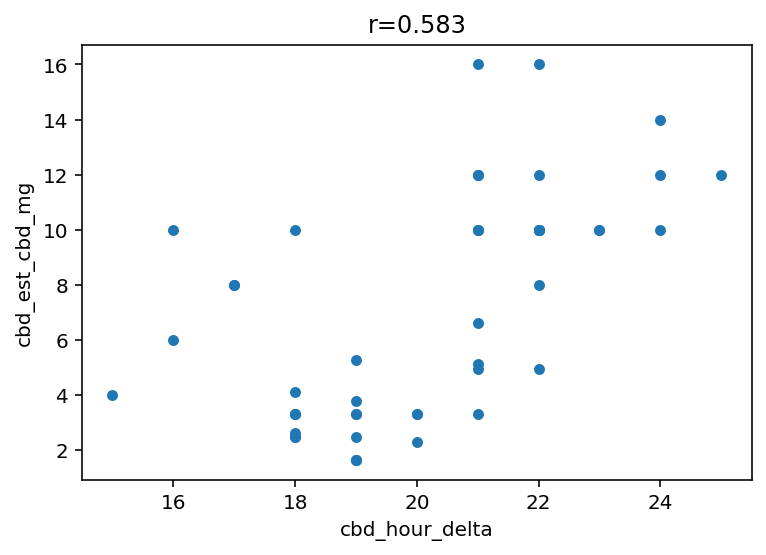

In [46]:
# Sidebar: let's do a scatterplot of the CBD dose vs CBD hour and look at correlation.
_df = df_cbd[df_cbd.cbd_hour_delta > 12]
cbd_r = np.corrcoef(_df[['cbd_est_cbd_mg', 'cbd_hour_delta']].T)[0,1]
_df.plot(kind='scatter', x='cbd_hour_delta', y='cbd_est_cbd_mg', title=f'r={cbd_r:.3f}')
plt.savefig(FIGSDIR/'01b_cbd_correlations.eps')
plt.show()

### Zero
Let's engineer some features on the fasting data from Zero

In [47]:
df_zero = zero.ingest(RAWDATADIR/'zero.csv')
df_zero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   zero_date          608 non-null    datetime64[ns]
 1   zero_end           608 non-null    object        
 2   zero_end_time      608 non-null    object        
 3   zero_hours         608 non-null    int64         
 4   zero_night_eating  573 non-null    float64       
 5   zero_start         608 non-null    object        
 6   zero_start_time    608 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 33.4+ KB


In [48]:
df_zero.sample(5)

,zero_date,zero_end,zero_end_time,zero_hours,zero_night_eating,zero_start,zero_start_time
212,2020-06-25,11:07 AM,11:07:00,13,3.0,9:21 PM,21:21:00
38,2020-12-16,3:22 PM,15:22:00,17,1.0,9:45 PM,21:45:00
55,2020-11-29,2:36 PM,14:36:00,15,3.0,11:03 PM,23:03:00
280,2020-04-19,12:05 PM,12:05:00,15,2.0,8:30 PM,20:30:00
542,2018-05-09,5:41 PM,17:41:00,16,6.0,12:45 AM,00:45:00


The date field seems to be linked with when the fast was started. This has the same wrapping issue as other data source that would throw off our models. We can construct a `summary_date` feature like we have for other data sources to help with aligning the datasets later.

In [49]:
# TODO generalise this function and allow the threshold time as a parameter
def summ_date(date, start):
    if start < pd.Timestamp('8:00:00').time():
        return date - pd.Timedelta('1D')
    else:
        return date

df_zero['zero_summary_date'] = df_zero.apply(lambda x: summ_date(x['zero_date'], x['zero_start_time']), axis=1)
df_zero.sort_values(by='zero_summary_date', inplace=True)

It'll also be useful to have numeric features for the start and end times of the fast. They should be delta (h) since the start of the summary date to avoide midnight wrapping.

In [50]:
def tstamp_to_hour_float(t):
    return pd.Timedelta(str(t))/np.timedelta64(1, 'h')

def midnight_unwrap(time):
    t = tstamp_to_hour_float(time)
    if 0.0 <= t < 12.0: #  Assume any fasts before midday are tied to previous day
        return t + 24.0
    else:
        return t

In [51]:
df_zero['zero_start_hour_delta'] = df_zero['zero_start_time'].apply(midnight_unwrap)

But in terms of sleeping, the _start_ of the _current_ fast is important and the _end_ of the _previous_ fast is important. We need to engineer a feature for the previous fast end time with reference to the summary date. The cleanest way to do this is probably to use a sort and shift on a duplicate of the end time feature (but including the date so we can cancel ones that aren't sequential).

In [52]:
df_zero['zero_end_timestamp'] = pd.to_datetime(
    pd.to_timedelta(df_zero['zero_end_time'].astype(str)) 
    + df_zero['zero_summary_date'] 
    + pd.to_timedelta(df_zero['zero_hours']//24 + 1,'D'))

df_zero['zero_start_timestamp'] = pd.to_datetime(
    pd.to_timedelta(df_zero['zero_start_time'].astype(str)) 
    + df_zero['zero_date'])

# Now we make a new column that shifts the fast end timestamp by one (i.e. now the last fast)
df_zero['zero_prev_fast_end'] = df_zero['zero_end_timestamp'].shift(1)

# Now we construct a feature for the time since the last fast
df_zero['zero_time_since_prev_fast'] = df_zero['zero_start_timestamp'] - df_zero['zero_prev_fast_end']

In [53]:
df_zero[125:135]

,zero_date,zero_end,zero_end_time,zero_hours,zero_night_eating,zero_start,zero_start_time,zero_summary_date,zero_start_hour_delta,zero_end_timestamp,zero_start_timestamp,zero_prev_fast_end,zero_time_since_prev_fast
482,2018-07-03,10:46 AM,10:46:00,11,5.0,11:04 PM,23:04:00,2018-07-03,23.066667,2018-07-04 10:46:00,2018-07-03 23:04:00,2018-07-03 12:47:00,0 days 10:17:00
481,2018-07-04,12:17 PM,12:17:00,12,5.0,11:35 PM,23:35:00,2018-07-04,23.583333,2018-07-05 12:17:00,2018-07-04 23:35:00,2018-07-04 10:46:00,0 days 12:49:00
480,2018-07-06,10:26 AM,10:26:00,10,6.0,12:21 AM,00:21:00,2018-07-05,24.350000,2018-07-06 10:26:00,2018-07-06 00:21:00,2018-07-05 12:17:00,0 days 12:04:00
479,2018-07-06,12:24 PM,12:24:00,13,5.0,11:00 PM,23:00:00,2018-07-06,23.000000,2018-07-07 12:24:00,2018-07-06 23:00:00,2018-07-06 10:26:00,0 days 12:34:00
478,2018-07-07,12:26 PM,12:26:00,13,5.0,11:00 PM,23:00:00,2018-07-07,23.000000,2018-07-08 12:26:00,2018-07-07 23:00:00,2018-07-07 12:24:00,0 days 10:36:00
477,2019-10-05,1:23 PM,13:23:00,14,NaN,11:00 PM,23:00:00,2019-10-05,23.000000,2019-10-06 13:23:00,2019-10-05 23:00:00,2018-07-08 12:26:00,454 days 10:34:00
476,2019-10-06,1:42 PM,13:42:00,14,NaN,11:10 PM,23:10:00,2019-10-06,23.166667,2019-10-07 13:42:00,2019-10-06 23:10:00,2019-10-06 13:23:00,0 days 09:47:00
475,2019-10-07,1:45 PM,13:45:00,15,NaN,10:14 PM,22:14:00,2019-10-07,22.233333,2019-10-08 13:45:00,2019-10-07 22:14:00,2019-10-07 13:42:00,0 days 08:32:00
474,2019-10-09,1:26 PM,13:26:00,11,NaN,2:15 AM,02:15:00,2019-10-08,26.250000,2019-10-09 13:26:00,2019-10-09 02:15:00,2019-10-08 13:45:00,0 days 12:30:00
473,2019-10-10,3:24 PM,15:24:00,13,NaN,2:00 AM,02:00:00,2019-10-09,26.000000,2019-10-10 15:24:00,2019-10-10 02:00:00,2019-10-09 13:26:00,0 days 12:34:00


It's highly likely that this shifting method will result in misinformed time_since_prev_fast features because of failures in tracking every day. From my protocol, I know that I never fast for more than 24h, so anything longer than 1 day can safely be set to NaN (in this case). 

In [54]:
df_zero['zero_time_since_prev_fast'] = df_zero['zero_time_since_prev_fast'].apply(
    lambda x: x if (x > pd.Timedelta(1,'m') and x < pd.Timedelta(1, 'D')) else np.NaN)

In [55]:
df_zero['zero_time_since_prev_fast'].describe()

count                       600
mean     0 days 10:20:46.400000
std      0 days 02:56:42.697252
min             0 days 00:13:00
25%             0 days 08:32:45
50%             0 days 10:17:00
75%             0 days 12:01:00
max             0 days 23:00:00
Name: zero_time_since_prev_fast, dtype: object

And then we should just make many of the features numeric.

In [56]:
df_zero['zero_hours_since_prev_fast'] = df_zero['zero_time_since_prev_fast'] / np.timedelta64(1, 'h')
df_zero['zero_prev_end_hour_delta'] = df_zero['zero_prev_fast_end'].dt.hour

In [57]:
df_zero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 608 entries, 607 to 0
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   zero_date                   608 non-null    datetime64[ns] 
 1   zero_end                    608 non-null    object         
 2   zero_end_time               608 non-null    object         
 3   zero_hours                  608 non-null    int64          
 4   zero_night_eating           573 non-null    float64        
 5   zero_start                  608 non-null    object         
 6   zero_start_time             608 non-null    object         
 7   zero_summary_date           608 non-null    datetime64[ns] 
 8   zero_start_hour_delta       608 non-null    float64        
 9   zero_end_timestamp          608 non-null    datetime64[ns] 
 10  zero_start_timestamp        608 non-null    datetime64[ns] 
 11  zero_prev_fast_end          607 non-null    d

In [58]:
df_zero.sample(10)

,zero_date,zero_end,zero_end_time,zero_hours,zero_night_eating,zero_start,zero_start_time,zero_summary_date,zero_start_hour_delta,zero_end_timestamp,zero_start_timestamp,zero_prev_fast_end,zero_time_since_prev_fast,zero_hours_since_prev_fast,zero_prev_end_hour_delta
501,2018-06-16,9:00 AM,09:00:00,8,6.0,12:30 AM,00:30:00,2018-06-15,24.500000,2018-06-16 09:00:00,2018-06-16 00:30:00,2018-06-15 13:04:00,11:26:00,11.433333,13.0
200,2020-07-07,2:29 PM,14:29:00,16,4.0,10:00 PM,22:00:00,2020-07-07,22.000000,2020-07-08 14:29:00,2020-07-07 22:00:00,2020-07-07 14:46:00,07:14:00,7.233333,14.0
42,2020-12-12,11:12 AM,11:12:00,12,2.0,10:20 PM,22:20:00,2020-12-12,22.333333,2020-12-13 11:12:00,2020-12-12 22:20:00,2020-12-12 12:52:00,09:28:00,9.466667,12.0
382,2020-01-09,5:32 PM,17:32:00,16,8.0,1:13 AM,01:13:00,2020-01-08,25.216667,2020-01-09 17:32:00,2020-01-09 01:13:00,2020-01-08 13:21:00,11:52:00,11.866667,13.0
539,2018-05-11,4:49 PM,16:49:00,17,4.0,10:49 PM,22:49:00,2018-05-11,22.816667,2018-05-12 16:49:00,2018-05-11 22:49:00,2018-05-11 15:28:00,07:21:00,7.350000,15.0
84,2020-10-31,10:15 AM,10:15:00,11,3.0,10:25 PM,22:25:00,2020-10-31,22.416667,2020-11-01 10:15:00,2020-10-31 22:25:00,2020-10-31 12:25:00,10:00:00,10.000000,12.0
464,2019-10-18,11:30 AM,11:30:00,12,NaN,10:33 PM,22:33:00,2019-10-18,22.550000,2019-10-19 11:30:00,2019-10-18 22:33:00,2019-10-18 12:02:00,10:31:00,10.516667,12.0
484,2018-07-01,10:30 AM,10:30:00,10,5.0,11:34 PM,23:34:00,2018-07-01,23.566667,2018-07-02 10:30:00,2018-07-01 23:34:00,2018-07-01 11:09:00,12:25:00,12.416667,11.0
267,2020-05-02,12:14 AM,00:14:00,3,3.0,9:03 PM,21:03:00,2020-05-02,21.050000,2020-05-03 00:14:00,2020-05-02 21:03:00,2020-05-02 10:34:00,10:29:00,10.483333,10.0
0,2021-01-23,11:24 AM,11:24:00,13,1.0,9:54 PM,21:54:00,2021-01-23,21.900000,2021-01-24 11:24:00,2021-01-23 21:54:00,2021-01-23 12:49:00,09:05:00,9.083333,12.0


In [59]:
ZERO_START = '2019-10-05' # Date when the fasting data in Zero is considered to have started

### RescueTime
Data from passively-logged computer usage

In [60]:
df_rt = rescue_time.ingest(RAWDATADIR/'RescueTime.csv')
df_rt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401 entries, 0 to 1400
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   rescue_business                1401 non-null   timedelta64[ns]
 1   rescue_coms_and_scheduling     1401 non-null   timedelta64[ns]
 2   rescue_date                    1401 non-null   datetime64[ns] 
 3   rescue_design                  1401 non-null   timedelta64[ns]
 4   rescue_distracting             1401 non-null   timedelta64[ns]
 5   rescue_entertainment           1401 non-null   timedelta64[ns]
 6   rescue_neutral                 1401 non-null   timedelta64[ns]
 7   rescue_news                    1401 non-null   timedelta64[ns]
 8   rescue_productive              1401 non-null   timedelta64[ns]
 9   rescue_reference_and_learning  1401 non-null   timedelta64[ns]
 10  rescue_shopping                1401 non-null   timedelta64[ns]
 11  resc

In [61]:
df_rt.tail(4)

,rescue_business,rescue_coms_and_scheduling,rescue_date,rescue_design,rescue_distracting,rescue_entertainment,rescue_neutral,rescue_news,rescue_productive,rescue_reference_and_learning,rescue_shopping,rescue_social_network,rescue_software_dev,rescue_total_distracting_time,rescue_total_productice_time,rescue_total_time,rescue_utilities,rescue_very_distracting,rescue_very_productice
1397,00:20:14,00:03:02,2021-01-19,00:18:33,00:02:00,00:05:18,00:20:00,00:00:56,00:38:05,00:59:50,0 days,00:05:58,00:55:19,00:12:43,02:53:00,03:26:00,00:26:00,00:10:43,02:15:00
1398,04:22:00,00:10:26,2021-01-20,00:24:35,00:02:29,00:02:37,00:33:57,00:00:23,04:50:00,00:18:54,0 days,00:04:59,00:07:28,00:08:03,05:22:00,06:04:00,00:28:53,00:05:34,00:31:59
1399,00:01:23,00:31:11,2021-01-21,00:13:35,00:24:19,00:19:31,00:42:23,00:00:03,00:54:52,00:31:15,0 days,00:07:33,02:03:00,00:28:50,03:14:00,04:25:00,00:33:05,00:04:31,02:19:00
1400,00:09:36,00:13:41,2021-01-22,00:42:55,00:03:32,00:02:31,00:44:59,00:00:53,00:45:14,00:30:13,0 days,00:05:55,02:48:00,00:07:06,04:34:00,05:26:00,00:41:38,00:03:34,03:49:00


For the purposes of training models, it makes sense to have everything stored in numeric types. Let's convert the timedeltas to floats (counting hours).

In [62]:
for c in df_rt.select_dtypes('timedelta64'): #  Look at all timedelta cols
    df_rt[c] = df_rt[c] / np.timedelta64(1, 'h')

df_rt.tail(4)

,rescue_business,rescue_coms_and_scheduling,rescue_date,rescue_design,rescue_distracting,rescue_entertainment,rescue_neutral,rescue_news,rescue_productive,rescue_reference_and_learning,rescue_shopping,rescue_social_network,rescue_software_dev,rescue_total_distracting_time,rescue_total_productice_time,rescue_total_time,rescue_utilities,rescue_very_distracting,rescue_very_productice
1397,0.337222,0.050556,2021-01-19,0.309167,0.033333,0.088333,0.333333,0.015556,0.634722,0.997222,0.0,0.099444,0.921944,0.211944,2.883333,3.433333,0.433333,0.178611,2.250000
1398,4.366667,0.173889,2021-01-20,0.409722,0.041389,0.043611,0.565833,0.006389,4.833333,0.315000,0.0,0.083056,0.124444,0.134167,5.366667,6.066667,0.481389,0.092778,0.533056
1399,0.023056,0.519722,2021-01-21,0.226389,0.405278,0.325278,0.706389,0.000833,0.914444,0.520833,0.0,0.125833,2.050000,0.480556,3.233333,4.416667,0.551389,0.075278,2.316667
1400,0.160000,0.228056,2021-01-22,0.715278,0.058889,0.041944,0.749722,0.014722,0.753889,0.503611,0.0,0.098611,2.800000,0.118333,4.566667,5.433333,0.693889,0.059444,3.816667


### HealthKit
Ingest hourly activity proxy (active energy) and flatten into daily record with hourly features.

In [63]:
df_hk = health_kit.ingest(RAWDATADIR/'HealthKit_1.csv')

df_hk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22279 entries, 0 to 22278
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   hk_start                   22279 non-null  datetime64[ns]
 1   hk_finish                  22279 non-null  datetime64[ns]
 2   hk_active_calories_(kcal)  22279 non-null  float64       
dtypes: datetime64[ns](2), float64(1)
memory usage: 522.3 KB


In [64]:
df_hk['hk_hour'] = df_hk['hk_start'].dt.hour
df_hk['hk_day'] = pd.to_datetime(df_hk['hk_start'].dt.date)

# Midnight unwrapping
df_hk['hk_day'] = df_hk['hk_day'].apply(datify)

In [65]:
df_hk.sample(5)

,hk_start,hk_finish,hk_active_calories_(kcal),hk_hour,hk_day
4714,2019-01-23 20:00:00,2019-01-23 21:00:00,0.000,20,2019-01-22
7593,2019-05-23 19:00:00,2019-05-23 20:00:00,4.181,19,2019-05-22
11953,2019-11-21 11:00:00,2019-11-21 12:00:00,79.000,11,2019-11-20
5975,2019-03-17 09:00:00,2019-03-17 10:00:00,27.490,9,2019-03-16
6546,2019-04-10 04:00:00,2019-04-10 05:00:00,0.000,4,2019-04-09


In [66]:
df_hk[df_hk.duplicated(subset=['hk_day', 'hk_hour'])]

,hk_start,hk_finish,hk_active_calories_(kcal),hk_hour,hk_day


I honestly can't figure out why Pandas thinks those are duplicates, but it's probably easier to just remove them.

In [67]:
df_hk.drop_duplicates(subset=['hk_day', 'hk_hour'], keep='first', inplace=True)

In [68]:
# Pivot and construct activity features for each of 24 hours in the day
df_act = df_hk.pivot(index='hk_day', columns='hk_hour', values='hk_active_calories_(kcal)')
df_act = pd.DataFrame(df_act.to_records()).rename(
    {str(x): f'hk_act_{x}h' for x in range(24)}, axis=1)

df_act.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   hk_day      929 non-null    object 
 1   hk_act_0h   928 non-null    float64
 2   hk_act_1h   928 non-null    float64
 3   hk_act_2h   928 non-null    float64
 4   hk_act_3h   928 non-null    float64
 5   hk_act_4h   928 non-null    float64
 6   hk_act_5h   928 non-null    float64
 7   hk_act_6h   928 non-null    float64
 8   hk_act_7h   928 non-null    float64
 9   hk_act_8h   928 non-null    float64
 10  hk_act_9h   928 non-null    float64
 11  hk_act_10h  929 non-null    float64
 12  hk_act_11h  929 non-null    float64
 13  hk_act_12h  929 non-null    float64
 14  hk_act_13h  929 non-null    float64
 15  hk_act_14h  929 non-null    float64
 16  hk_act_15h  929 non-null    float64
 17  hk_act_16h  929 non-null    float64
 18  hk_act_17h  928 non-null    float64
 19  hk_act_18h  928 non-null    f

In [69]:
df_act.tail(5)

,hk_day,hk_act_0h,hk_act_1h,hk_act_2h,hk_act_3h,hk_act_4h,hk_act_5h,hk_act_6h,hk_act_7h,hk_act_8h,...,hk_act_14h,hk_act_15h,hk_act_16h,hk_act_17h,hk_act_18h,hk_act_19h,hk_act_20h,hk_act_21h,hk_act_22h,hk_act_23h
924,2021-01-19,0.24,0.000,0.0,0.0,10.901,0.12,0.0,0.00,0.00,...,7.089,228.791,17.032,0.000,0.000,22.966,21.001,11.020,13.948,0.360
925,2021-01-20,0.00,0.000,0.0,0.0,0.000,0.00,0.0,0.00,0.00,...,10.817,18.839,75.110,181.974,66.737,42.849,60.404,40.843,43.488,5.771
926,2021-01-21,0.12,0.000,0.0,0.0,0.000,0.00,0.0,0.00,0.00,...,31.177,21.962,2.002,6.211,11.019,29.017,0.000,4.610,7.694,14.188
927,2021-01-22,0.00,0.521,0.0,0.0,0.000,0.00,0.0,0.12,0.00,...,28.015,32.904,1.643,4.609,48.736,113.228,31.943,39.038,4.688,14.870
928,2021-01-23,0.00,0.000,0.0,0.0,0.000,0.00,0.0,0.00,19.52,...,30.020,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


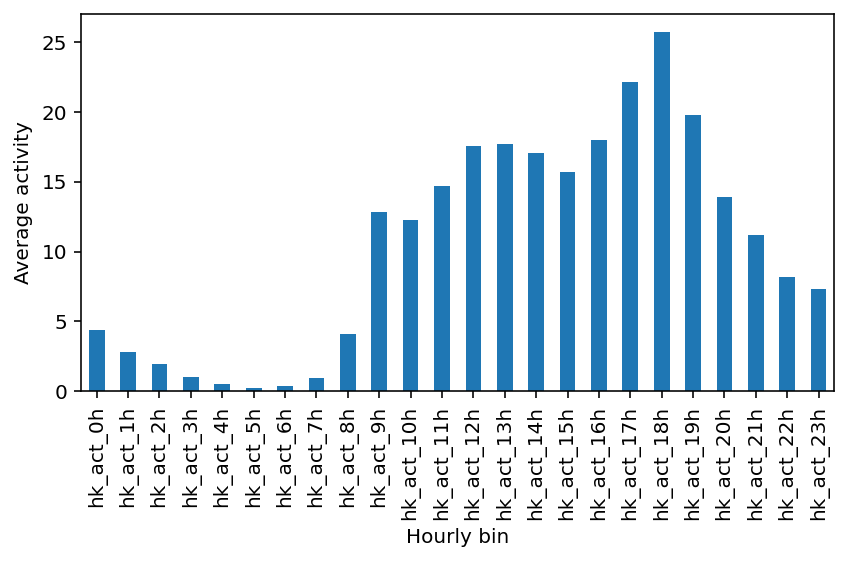

In [70]:
df_act.select_dtypes('float64').apply(np.mean).plot(kind='bar')
plt.ylabel('Average activity')
plt.xlabel('Hourly bin')
plt.tight_layout()
plt.savefig(FIGSDIR/'01b_healthkit_activity_hourly_bars.eps')
plt.show()

But this is too many features given the number of night's of data we have. Honestly, hourly is still too granular for this. Let's do a bit better!

In [71]:
df_act['hk_act_night_mean'] = df_act[[f'hk_act_{i}h' for i in range(0,5)]].apply(np.mean, axis=1)
df_act['hk_act_morn_mean'] = df_act[[f'hk_act_{i}h' for i in range(5,11)]].apply(np.mean, axis=1)
df_act['hk_act_afternoon_mean'] = df_act[[f'hk_act_{i}h' for i in range(11,17)]].apply(np.mean, axis=1)
df_act['hk_act_eve_mean'] = df_act[[f'hk_act_{i}h' for i in range(17,24)]].apply(np.mean, axis=1)
df_act.sample(5)

,hk_day,hk_act_0h,hk_act_1h,hk_act_2h,hk_act_3h,hk_act_4h,hk_act_5h,hk_act_6h,hk_act_7h,hk_act_8h,...,hk_act_18h,hk_act_19h,hk_act_20h,hk_act_21h,hk_act_22h,hk_act_23h,hk_act_night_mean,hk_act_morn_mean,hk_act_afternoon_mean,hk_act_eve_mean
135,2018-11-22,0.740,0.000,0.000,0.000,0.000,0.0,0.0,2.301,100.018,...,31.077,1.315,10.924,66.844,10.091,7.356,0.1480,25.292667,20.348167,18.264857
285,2019-04-21,0.121,1.648,0.402,6.069,2.452,0.0,0.0,0.000,0.000,...,0.000,0.000,0.000,0.000,3.256,0.000,2.1384,0.000000,59.603000,0.465143
860,2020-11-16,0.000,0.000,0.000,0.000,0.000,0.0,0.0,1.648,0.000,...,4.059,88.414,5.049,6.000,11.000,0.604,0.0000,1.108000,6.879333,17.275714
808,2020-09-25,2.000,1.000,0.000,0.000,0.000,0.0,0.0,0.121,5.408,...,83.000,6.121,7.000,3.121,3.050,0.241,0.6000,3.656000,19.939833,22.504714
643,2020-04-13,6.287,1.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,...,31.000,17.931,8.000,12.936,5.523,1.000,1.4574,0.000000,10.646500,11.484286


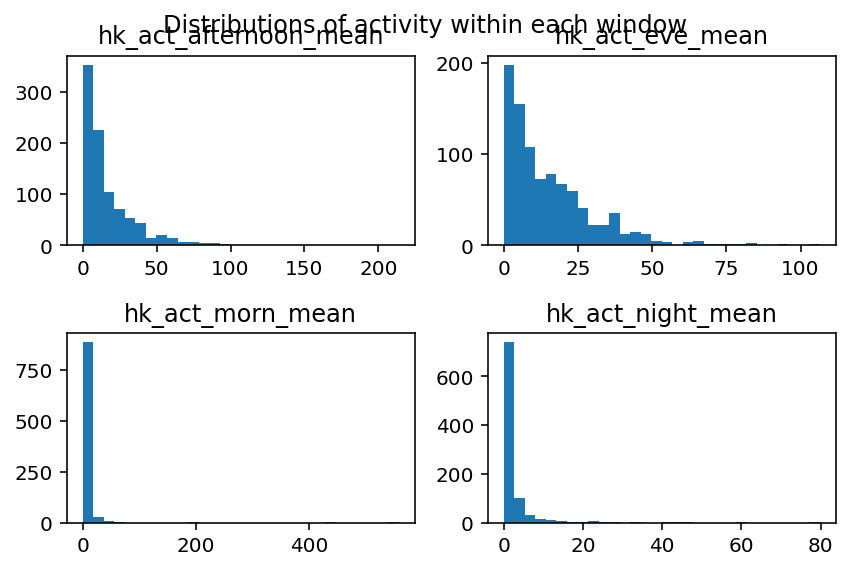

In [72]:
df_act[['hk_act_night_mean', 'hk_act_morn_mean', 'hk_act_afternoon_mean', 'hk_act_eve_mean']].hist(grid=False, bins=30)
plt.suptitle('Distributions of activity within each window')
plt.tight_layout()
plt.savefig(FIGSDIR/'01b_healthkit_activity_windows_distributions.eps')
plt.show()

### Melatonin


In [73]:
df_mel = melatonin.ingest(RAWDATADIR/'melatonin log - Sheet1.csv')
df_mel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   melatonin_date      141 non-null    datetime64[ns]
 1   melatonin_quantity  141 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.3 KB


Much like with CBD oil, we want to create a numeric feature for the hour the melatonin was taken and we want to avoid "midnight wrapping." We'll make use of the `datify()` function we wrote above.

In [74]:
df_mel['melatonin_summary_date'] = pd.to_datetime(df_mel['melatonin_date'].apply(datify))
df_mel['melatonin_hour_taken'] = df_mel['melatonin_date'].dt.hour
df_mel['melatonin_hour_delta'] = df_mel['melatonin_hour_taken'].apply(
    lambda x: x if x > 5 else x+24)

df_mel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   melatonin_date          141 non-null    datetime64[ns]
 1   melatonin_quantity      141 non-null    int64         
 2   melatonin_summary_date  141 non-null    datetime64[ns]
 3   melatonin_hour_taken    141 non-null    int64         
 4   melatonin_hour_delta    141 non-null    int64         
dtypes: datetime64[ns](2), int64(3)
memory usage: 5.6 KB


In [75]:
df_mel.sort_values(by='melatonin_summary_date', inplace=True)
df_mel = df_mel.groupby(['melatonin_summary_date', 'melatonin_hour_taken', 'melatonin_hour_delta']).sum().reset_index()

df_mel.tail()

,melatonin_summary_date,melatonin_hour_taken,melatonin_hour_delta,melatonin_quantity
130,2020-12-25,20,20,1
131,2020-12-30,20,20,1
132,2021-01-02,20,20,1
133,2021-01-13,20,20,1
134,2021-01-22,20,20,1


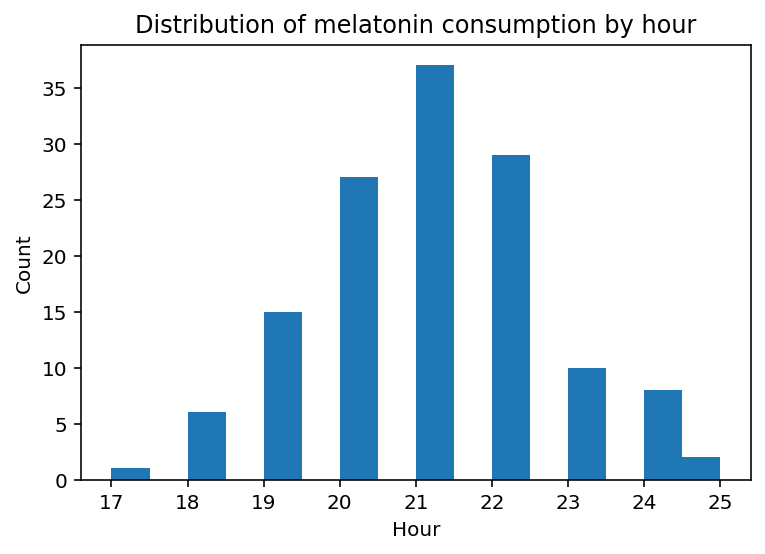

In [76]:
df_mel.melatonin_hour_delta.hist(grid=False, bins=2*(25-17))
plt.ylabel('Count')
plt.xlabel('Hour')
plt.title('Distribution of melatonin consumption by hour')
plt.savefig(FIGSDIR/'01b_melatoning_consumption_distribution_hour.eps')
plt.show()

### Nomie

In [77]:
df_nomie = nomie.ingest(RAWDATADIR/'nomie.csv')
df_nomie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5690 entries, 0 to 5689
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   nomie_end      5690 non-null   datetime64[ns]
 1   nomie_start    5690 non-null   datetime64[ns]
 2   nomie_tracker  5690 non-null   object        
 3   nomie_value    5670 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 177.9+ KB


In [78]:
df_nomie.head()

,nomie_end,nomie_start,nomie_tracker,nomie_value
0,2021-01-24 12:29:00,2021-01-24 12:28:59,caffeine,1.0
1,2021-01-24 11:09:50,2021-01-24 11:09:49,caffeine,1.0
2,2021-01-23 20:29:52,2021-01-23 20:29:51,alcohol,1.0
3,2021-01-23 18:16:51,2021-01-23 18:16:50,alcohol,1.0
4,2021-01-23 12:14:31,2021-01-23 12:14:30,caffeine,1.0


In [80]:
df_nomie[df_nomie.nomie_tracker.isin(['caffeine', 'alcohol'])]['nomie_value'].value_counts()

1.0    2888
3.0       2
Name: nomie_value, dtype: int64

We need to unpack these values. In terms of the rest of our data sources, it seems like we'd want some kind of daily summary with some totals as well as engineered features for first and last drinks, etc.

Let's first engineer the summary date feature and avoid midnight wrapping. This will be tricky to do for both alcohol and coffee as there's no obvious cutoff for the latest one might drink alcohol or the earliest one might drink coffee. 5 or 6 AM should minimise the overlap, but let's investigate first.

caffeine
04:42:04
23:40:27

alcohol
00:01:25
23:58:52



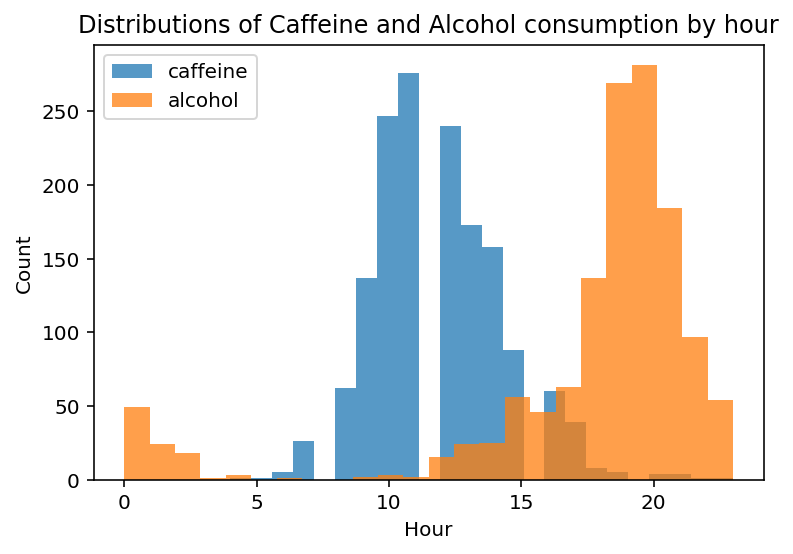

In [81]:
nb_trackers = ['caffeine', 'alcohol']
_df = df_nomie[df_nomie.nomie_tracker.isin(nb_trackers)]

fig, ax = plt.subplots()

for tracker in nb_trackers:
    times = _df[_df.nomie_tracker == tracker].nomie_start
    times.dt.hour.hist(bins=24, grid=False, ax=ax, label=tracker, alpha=0.75)
    print(tracker, times.dt.time.min(), times.dt.time.max(), sep='\n', end='\n\n')
    
plt.legend()
plt.title('Distributions of Caffeine and Alcohol consumption by hour')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.savefig(FIGSDIR/'01b_caffeine_alcohol_distributions.png', dpi=500)
plt.show()

So according to the above analysis, the cutoff is actually 3AM. That surprises me, to be honest. But potentially drinking alcohol after 3AM is a wild-enough night that I might forget to track (unlikely) or hit caffeine by mistake (more likely). 5 AM seems like a much more natural cutoff in the above histograms. It'll probably also generalise to future data better than this bespoke 3AM cutoff.


In [82]:
def nomie_summ_date(dtime):
    if 0 <= dtime.hour < 5:
        return pd.to_datetime(dtime.date() - pd.Timedelta('1D'))
    else:
        return pd.to_datetime(dtime.date())

In [83]:
df_nomie['nomie_summary_date'] = df_nomie['nomie_start'].apply(nomie_summ_date)

df_nomie.head()

,nomie_end,nomie_start,nomie_tracker,nomie_value,nomie_summary_date
0,2021-01-24 12:29:00,2021-01-24 12:28:59,caffeine,1.0,2021-01-24
1,2021-01-24 11:09:50,2021-01-24 11:09:49,caffeine,1.0,2021-01-24
2,2021-01-23 20:29:52,2021-01-23 20:29:51,alcohol,1.0,2021-01-23
3,2021-01-23 18:16:51,2021-01-23 18:16:50,alcohol,1.0,2021-01-23
4,2021-01-23 12:14:31,2021-01-23 12:14:30,caffeine,1.0,2021-01-23


Now let's split caffeine and alcohol with appropriate labels and begin feature engineering

In [84]:
def nomie_net_hour(dtime):
    if 0 <= dtime.hour < 5:
        return int(dtime.hour + 24)
    else:
        return int(dtime.hour)

def arr_range(arr):
    # custom range function that we can rename
    return np.max(arr) - np.min(arr)

# We rename the function so that pandas names the field "range"
arr_range.__name__ = 'range'

def spread(arr):
    # Custom function for variance, but with no NaNs
    if np.isnan(np.var(arr)):
        return 0.0
    else:
        return np.var(arr)
    
# We rename this function too
spread.__name__ = 'spread'

def nomie_feat_eng(df: pd.DataFrame, tracker: str):
    # Generates new DF from nomie DF with engineered features for some tracker
    
    _df = df.copy() #  Only work on a copy of the passed DF
    
    # Engineer the net hour feature
    _df[f'nomie_net_hour'] = _df['nomie_start'].apply(nomie_net_hour)
    
    _dfx = _df[_df['nomie_tracker'] == tracker].groupby('nomie_summary_date').agg({
        'nomie_value': 'sum',
        'nomie_net_hour': ['min', 'max', arr_range, spread],

    }).reset_index()

    # We collapse the multi-index and concatenate the names (beautiful!)
    _dfx.columns = _dfx.columns.to_series().str.join('_')
    
    # Inject the prefix from the tracker name into labels
    pref = tracker[:3]
    _dfx.rename(
        {c: f"nomie_{pref}_{'_'.join(c.split('_')[1:])}" for c in _dfx.columns}, 
        axis=1, inplace=True)
    
    return _dfx

In [85]:
df_alc = nomie_feat_eng(df_nomie, 'alcohol')
df_caf = nomie_feat_eng(df_nomie, 'caffeine')

df_caf.tail(5)

,nomie_caf_summary_date_,nomie_caf_value_sum,nomie_caf_net_hour_min,nomie_caf_net_hour_max,nomie_caf_net_hour_range,nomie_caf_net_hour_spread
590,2021-01-20,3.0,12,16,4,2.888889
591,2021-01-21,2.0,10,11,1,0.250000
592,2021-01-22,2.0,12,12,0,0.000000
593,2021-01-23,2.0,11,12,1,0.250000
594,2021-01-24,2.0,11,12,1,0.250000


In [86]:
print(df_caf.tail(5).to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} & nomie\_caf\_summary\_date\_ &  nomie\_caf\_value\_sum &  nomie\_caf\_net\_hour\_min &  nomie\_caf\_net\_hour\_max &  nomie\_caf\_net\_hour\_range &  nomie\_caf\_net\_hour\_spread \\
\midrule
590 &              2021-01-20 &                  3.0 &                      12 &                      16 &                         4 &                   2.888889 \\
591 &              2021-01-21 &                  2.0 &                      10 &                      11 &                         1 &                   0.250000 \\
592 &              2021-01-22 &                  2.0 &                      12 &                      12 &                         0 &                   0.000000 \\
593 &              2021-01-23 &                  2.0 &                      11 &                      12 &                         1 &                   0.250000 \\
594 &              2021-01-24 &                  2.0 &                      11 &                      12 &    

### Way of Life (habits)

In [87]:
df_wol = way_of_life.ingest(RAWDATADIR/'Way of Life (2021-01-24).csv')
df_wol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   wol_7-min_workout               89 non-null     float64       
 1   wol_added_to_anki               270 non-null    float64       
 2   wol_brush_teeth_before_bed      510 non-null    float64       
 3   wol_caffeinated_drinks_<=_2     643 non-null    float64       
 4   wol_daily_metrics               545 non-null    float64       
 5   wol_date                        707 non-null    datetime64[ns]
 6   wol_deep_work                   88 non-null     float64       
 7   wol_deliberate_practice_/_lear  88 non-null     float64       
 8   wol_flow_state                  88 non-null     float64       
 9   wol_formal_meditation           510 non-null    float64       
 10  wol_hip_stretches               14 non-null     float64       
 11  wol_in

In [88]:
df_wol.sample(5).T

,610,677,665,48,529
wol_7-min_workout,NaN,0,0,NaN,NaN
wol_added_to_anki,0,0,0,NaN,0
wol_brush_teeth_before_bed,1,0,0,NaN,1
wol_caffeinated_drinks_<=_2,1,1,0,NaN,1
wol_daily_metrics,0,0,1,NaN,0
wol_date,2020-10-19 00:00:00,2020-12-25 00:00:00,2020-12-13 00:00:00,2019-03-30 00:00:00,2020-07-30 00:00:00
wol_deep_work,NaN,0,1,NaN,NaN
wol_deliberate_practice_/_lear,NaN,0,1,NaN,NaN
wol_flow_state,NaN,0,1,NaN,NaN
wol_formal_meditation,0,0,0,NaN,0


### Mood data from Sitrus

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


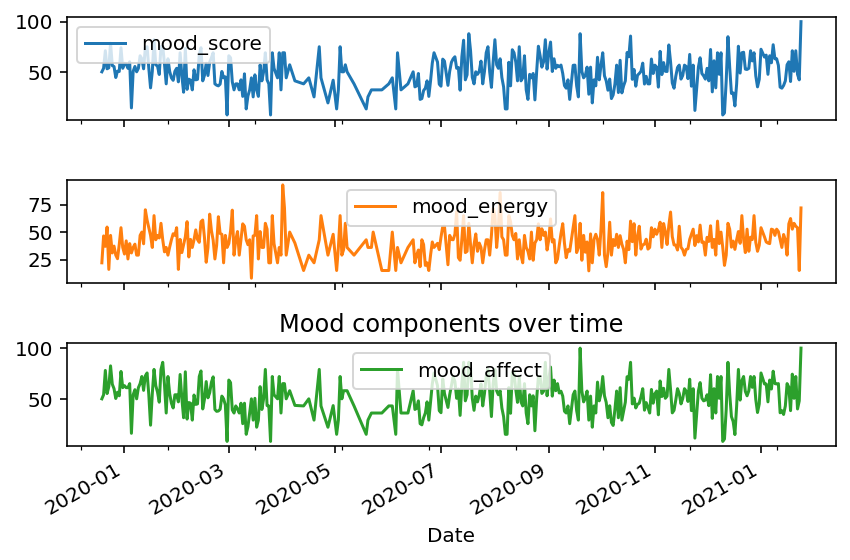

,mood_date,mood_score,mood_energy,mood_affect
206,2020-08-28,54.666667,53.0,55.333333
32,2020-01-20,55.666667,47.0,56.666667
278,2020-11-09,76.800000,56.0,79.000000


In [89]:
df_mood = sitrus.ingest(RAWDATADIR / 'mood.csv')
df_mood.shape
mood_cols = ['mood_time', 'mood_score', 'mood_energy', 'mood_affect']
df_mood = df_mood[mood_cols]
df_mood = df_mood.sort_values('mood_time', ascending=True)
df_mood['mood_date'] = df_mood['mood_time'].apply(datify)

df_mood = df_mood.groupby('mood_date').mean().reset_index()

df_mood.set_index('mood_date').plot(subplots=True, layout=(3,1))
plt.title('Mood components over time')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig(FIGSDIR/'01b_mood_components_over_time.eps')
plt.show()
df_mood.shape

df_mood.sample(3)

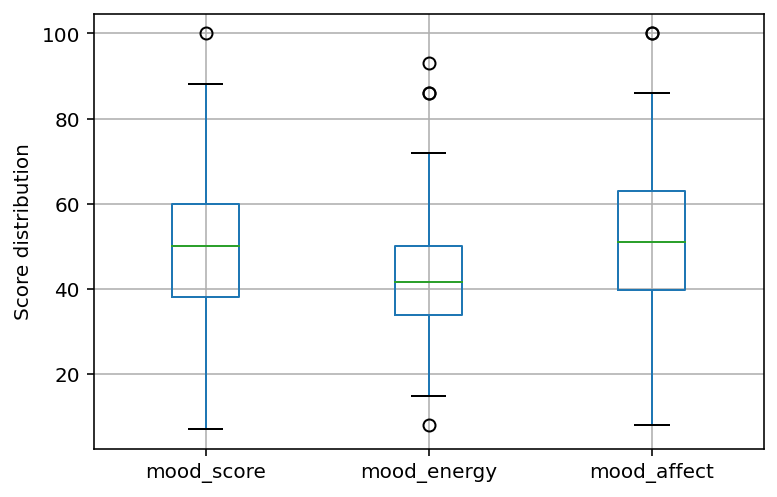

In [90]:
df_mood.boxplot()
plt.ylabel('Score distribution')
plt.savefig(FIGSDIR/'01b_mood_components_boxplots.eps')
plt.show()

### Data from AWARE

In [91]:
df_aw_act = aware_activities.ingest(RAWDATADIR / 'activities.csv')
print('Activities:', df_aw_act.shape)

df_aw_call = aware_calls.ingest(RAWDATADIR / 'calls.csv')
print('Calls:', df_aw_call.shape)

df_aw_loc = aware_locations.ingest(RAWDATADIR / 'locations.csv')
print('Locations:', df_aw_loc.shape)

df_aw_weath = aware_weather.ingest(RAWDATADIR / 'weather.csv')
print('Weather:', df_aw_weath.shape)

df_aw_hr = aware_heart_rate.ingest(RAWDATADIR / 'heart_rate.csv')
print('Heart rate:', df_aw_hr.shape)

Activities: (956859, 8)
Calls: (1353, 4)
Locations: (133926, 8)
Weather: (21512, 13)
Heart rate: (3294616, 5)


#### Weather data

In [92]:
df_aw_weath.sample(3).T

,11721,12006,20228
aw_weather_city,Saldanha,Saldanha,Saldanha
aw_weather_cloudiness,69,53,0
aw_weather_humidity,93,81,77
aw_weather_pressure,1018,1030,1013
aw_weather_rain,0,0,0
aw_weather_sunrise,07:12:56,07:07:58,05:47:41
aw_weather_sunset,18:26:58,18:29:34,20:00:30
aw_weather_temperature,13,6,17
aw_weather_temperature_max,13,6,17
aw_weather_temperature_min,13,6,17


In [93]:
df_aw_weath['aw_weather_date'] = df_aw_weath['aw_weather_timestamp'].apply(datify)
df_aw_weath = df_aw_weath.groupby('aw_weather_date').agg(['median', 'std'])
# We collapse the multi-index and concatenate the names (beautiful!)
df_aw_weath.columns = df_aw_weath.columns.to_series().str.join('_')
df_aw_weath.reset_index(inplace=True)

df_aw_weath.sample(3).T

,26,317,289
aw_weather_date,2020-02-08,2020-12-06,2020-11-08
aw_weather_cloudiness_median,98,2,43
aw_weather_cloudiness_std,26.3726,23.9798,25.7654
aw_weather_humidity_median,93,82,76
aw_weather_humidity_std,5.46601,17.3764,13.8216
aw_weather_pressure_median,1016,1011,1017
aw_weather_pressure_std,1.42413,1.03381,3.99354
aw_weather_rain_median,0,0,0
aw_weather_rain_std,0.122157,0,0
aw_weather_temperature_median,7.78,16,16


#### Location data

In [94]:
df_aw_loc.sample(3)

,aw_loc_accuracy,aw_loc_altitude,aw_loc_bearing,aw_loc_lat,aw_loc_lon,aw_loc_provider,aw_loc_speed,aw_loc_timestamp
117788,65,119.928158,-1.0,-33.794967,18.973589,gps,-1.0,2020-12-11 19:26:02
124964,65,1388.707767,-1.0,-26.767374,27.706793,fused,-1.0,2020-12-31 02:56:33
122778,65,121.223015,-1.0,-33.794832,18.973817,fused,-1.0,2020-12-24 23:38:14


In [95]:
# Check how many low-accuracy points exist
df_aw_loc[df_aw_loc.aw_loc_accuracy <= 65].shape, df_aw_loc[df_aw_loc.aw_loc_accuracy.between(65, 200)].shape, df_aw_loc.shape

((114757, 8), (119243, 8), (133926, 8))

In [96]:
import folium
import pygeohash as pgh

In [ ]:
m = folium.Map(
    location=[0.0, 0.0],
    zoom_start=3,
    tiles='Stamen Terrain'
)


for ind, row in df_aw_loc.sample(1000).iterrows():
    folium.Marker([row['aw_loc_lat'], row['aw_loc_lon']], popup=f"acc:{row['aw_loc_accuracy']}").add_to(m)

m

We can use [geohashes](https://www.movable-type.co.uk/scripts/geohash.html) to encode the position in a useful way!

In [98]:
# Calculate the level-9 geohashes for each pair of coordinates and make into a new features
df_aw_loc['aw_geohash9'] = df_aw_loc.apply(lambda x: pgh.encode(x['aw_loc_lat'], x['aw_loc_lon'], 9), axis=1)

# Truncate the level-9 geohashes to get the level- 5, 6, 7, 8 geohashes (more efficient than re-computing) and make into features
for i in range(5, 9):
    df_aw_loc[f'aw_geohash{i}'] = df_aw_loc['aw_geohash9'].str[:i]

In [100]:
# Get the most frequent level-5 geohashes (so we can make them into features)
freq_geos = list(df_aw_loc.aw_geohash5.value_counts().head(10).index)

# Make features by one-hot-encoding frequent level-5 geohashes
new_geo_cols= []
for geo in freq_geos:
    col_name = f"aw_loc_geohash_{geo}"
    df_aw_loc[col_name] = df_aw_loc['aw_geohash5'].apply(lambda x: 1 if x == geo else 0)
    new_geo_cols.append(col_name)

# Midnight unwrapping
df_aw_loc['aw_loc_date'] = df_aw_loc['aw_loc_timestamp'].apply(datify)

Now we can group by the date columna and perform extensive custom aggregations

In [ ]:
def num_unique(vals):
    return len(list(set(vals)))

aggregation_dict = {k: ['mean'] for k in new_geo_cols}
aggregation_dict['aw_loc_altitude'] = ['mean']
aggregation_dict['aw_loc_speed'] = ['max']
for col in [c for c in df_aw_loc.columns if c[:10] == 'aw_geohash']:
    aggregation_dict[col] = [num_unique]

df_aw_loc = df_aw_loc.groupby('aw_loc_date').agg(aggregation_dict).reset_index()

# We collapse the multi-index and concatenate the names (beautiful!)
df_aw_loc.columns = df_aw_loc.columns.to_series().str.join('_')

df_aw_loc.sample(5).T

#### Call data

In [ ]:
df_aw_call.sample(3)

In [103]:
# Drop some features
df_aw_call.drop('aw_calls_trace', axis=1, inplace=True)
# Apply midnight wrapping function
df_aw_call['aw_calls_date'] = df_aw_call['aw_calls_timestamp'].apply(datify)
# Aggregate calls by date
df_aw_call = df_aw_call.groupby('aw_calls_date').agg({
    'aw_calls_call_duration': ['mean', 'max', 'std', 'count'],
}).reset_index()

# We collapse the multi-index and concatenate the names (beautiful!)
df_aw_call.columns = df_aw_call.columns.to_series().str.join('_')

# Replace some nans
df_aw_call['aw_calls_call_duration_std'].fillna(0, inplace=True)

df_aw_call.sample(3)

,aw_calls_date_,aw_calls_call_duration_mean,aw_calls_call_duration_max,aw_calls_call_duration_std,aw_calls_call_duration_count
39,2020-03-17,188.833333,817,326.890451,6
148,2020-08-29,18.000000,50,24.883730,6
173,2020-10-29,900.333333,2691,1550.770884,3


#### Activity data

In [104]:
df_aw_act.sample(5)

,aw_activ_automotive,aw_activ_confidence,aw_activ_cycling,aw_activ_running,aw_activ_stationary,aw_activ_timestamp,aw_activ_unknown,aw_activ_walking
370409,0,2,0,0,1,2020-06-01 02:55:44,0,0
831422,0,2,0,0,1,2020-11-14 20:24:15,0,0
822069,0,2,0,0,1,2020-11-09 02:56:55,0,0
547835,0,2,0,0,1,2020-07-16 11:06:48,0,0
897028,0,1,0,0,0,2020-12-23 02:08:00,0,1


In [105]:
df_aw_act['aw_activ_confidence'].value_counts()

2    930274
1     26585
Name: aw_activ_confidence, dtype: int64

Drop rows where the confidence in the activity is low (<2) and then drop confidence column.

In [106]:
df_aw_act = df_aw_act[df_aw_act['aw_activ_confidence'] >= 2].drop('aw_activ_confidence', axis=1)

We can also remove the unknown activity column

In [107]:
df_aw_act.drop('aw_activ_unknown', axis=1, inplace=True)

Resample and forward-fill, then apply our `datify` function to do midnight unwrapping.

In [108]:
df_aw_act = df_aw_act.set_index('aw_activ_timestamp').resample('1min').max().ffill().reset_index()
df_aw_act['aw_activ_date'] = df_aw_act['aw_activ_timestamp'].apply(datify)

Group by the date field and perform mean aggregation. This gives us the fraction of the day that the activity made up.

In [109]:
df_aw_act = df_aw_act.groupby('aw_activ_date').mean().reset_index()
df_aw_act.sample(3)

,aw_activ_date,aw_activ_automotive,aw_activ_cycling,aw_activ_running,aw_activ_stationary,aw_activ_walking
217,2020-08-17,0.005556,0.0,0.000000,0.932639,0.057639
357,2021-01-04,0.027083,0.0,0.000000,0.844444,0.102083
119,2020-05-11,0.026389,0.0,0.000694,0.819444,0.093056


#### Heart rate

In [110]:
df_aw_hr.sample(5)

,aw_hr_device,aw_hr_end_time,aw_hr_heart_rate,aw_hr_log_timestamp,aw_hr_start_time
2310554,Mi Smart Band 4,2020-09-26 18:37:17,97,2020-09-26 19:02:22,2020-09-26 18:37:17
316886,Mi Smart Band 4,2020-02-03 13:44:28,101,2020-02-03 13:51:28,2020-02-03 13:44:28
361274,Mi Smart Band 4,2020-02-07 19:38:14,78,2020-02-07 19:44:43,2020-02-07 19:38:14
350748,Mi Smart Band 4,2020-02-06 16:05:20,64,2020-02-06 18:17:27,2020-02-06 16:05:20
505710,Mi Smart Band 4,2020-02-25 16:25:02,96,2020-02-25 16:35:51,2020-02-25 16:25:02


In [111]:
unknown = df_aw_hr[df_aw_hr.aw_hr_device == 'unknown']
mi_band = df_aw_hr[~(df_aw_hr.aw_hr_device == 'unknown')]

unknown.shape, mi_band.shape

((685666, 5), (2608950, 5))

,aw_hr_device_un,aw_hr_end_time_un,aw_hr_heart_rate_un,aw_hr_log_timestamp_un,aw_hr_start_time,aw_hr_device_mi,aw_hr_end_time_mi,aw_hr_heart_rate_mi,aw_hr_log_timestamp_mi
3171,unknown,2020-01-11 13:02:59,76.0,2020-01-14 00:46:34,2020-01-11 13:02:00,Mi Smart Band 4,2020-01-11 13:02:00,73.0,2020-01-14 00:46:34
3172,unknown,2020-01-11 13:02:59,76.0,2020-01-14 00:46:34,2020-01-11 13:02:00,Mi Smart Band 4,2020-01-11 13:02:00,75.0,2020-01-14 00:46:34
3173,unknown,2020-01-11 13:02:59,76.0,2020-01-14 00:46:34,2020-01-11 13:02:00,Mi Smart Band 4,2020-01-11 13:02:00,73.0,2020-01-14 00:46:34
3174,unknown,2020-01-11 13:02:59,76.0,2020-01-14 00:46:34,2020-01-11 13:02:00,Mi Smart Band 4,2020-01-11 13:02:00,75.0,2020-01-14 00:46:34
3175,unknown,2020-01-11 13:02:59,76.0,2020-01-14 00:46:34,2020-01-11 13:02:00,Mi Smart Band 4,2020-01-11 13:02:00,73.0,2020-01-14 00:46:34
...,...,...,...,...,...,...,...,...,...
505751,unknown,2020-05-29 17:50:59,75.0,2020-05-29 19:24:30,2020-05-29 17:50:00,Mi Smart Band 4,2020-05-29 17:50:00,76.0,2020-05-29 19:24:30
505752,unknown,2020-05-29 17:50:59,75.0,2020-05-29 19:24:30,2020-05-29 17:50:00,Mi Smart Band 4,2020-05-29 17:50:00,76.0,2020-05-29 19:24:30
505899,unknown,2020-05-29 19:33:59,74.0,2020-05-29 19:56:28,2020-05-29 19:33:00,Mi Smart Band 4,2020-05-29 19:33:00,70.0,2020-05-29 19:56:28
505903,unknown,2020-05-29 19:37:59,75.0,2020-05-29 19:56:28,2020-05-29 19:37:00,Mi Smart Band 4,2020-05-29 19:37:00,71.0,2020-05-29 19:56:28


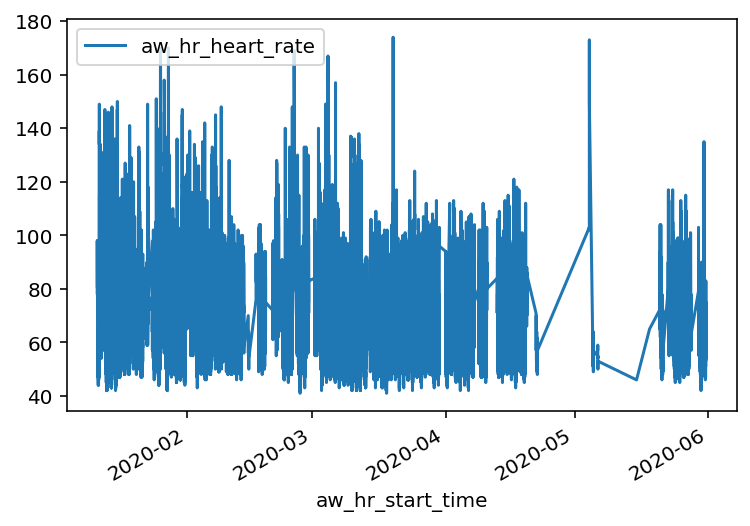

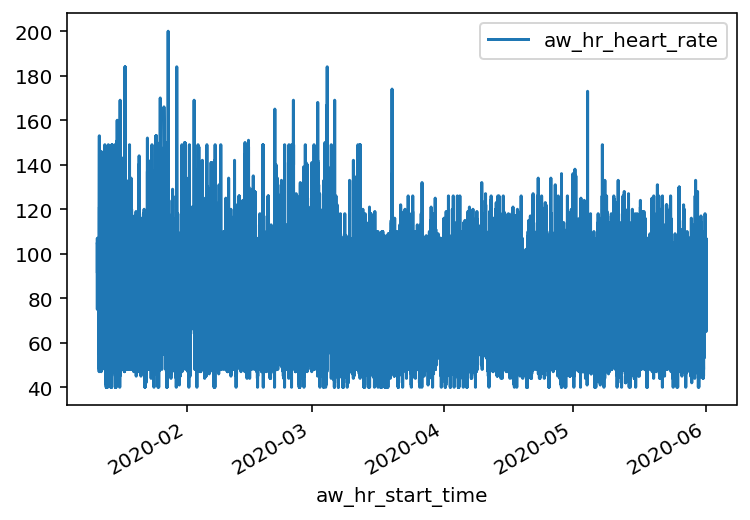

In [112]:
DATE_START = '2020-01-01'
DATE_END = '2020-06-01'

a = unknown[unknown.aw_hr_start_time.between(DATE_START, DATE_END)]
b = mi_band[mi_band.aw_hr_start_time.between(DATE_START, DATE_END)]

a.shape

a.set_index('aw_hr_start_time').plot(y='aw_hr_heart_rate')
b.set_index('aw_hr_start_time').plot(y='aw_hr_heart_rate')

comp = a.merge(b, how='outer', on='aw_hr_start_time', suffixes=('_un', '_mi'))
comp[comp.isna().sum(axis=1) == 0]

In [113]:
df_aw_hr.shape, df_aw_hr.drop_duplicates(subset=['aw_hr_heart_rate', 'aw_hr_start_time'], keep='first').shape

((3294616, 5), (2421347, 5))

In [114]:
df_aw_hr = df_aw_hr.drop_duplicates(subset=['aw_hr_heart_rate', 'aw_hr_start_time'], keep='first').reset_index(drop=True)
df_aw_hr.head()

,aw_hr_device,aw_hr_end_time,aw_hr_heart_rate,aw_hr_log_timestamp,aw_hr_start_time
0,unknown,2020-01-11 01:23:59,81,2020-01-14 00:46:34,2020-01-11 01:23:00
1,unknown,2020-01-11 01:25:59,85,2020-01-14 00:46:34,2020-01-11 01:25:00
2,unknown,2020-01-11 01:26:59,84,2020-01-14 00:46:34,2020-01-11 01:26:00
3,unknown,2020-01-11 01:27:59,86,2020-01-14 00:46:34,2020-01-11 01:27:00
4,Mi Smart Band 4,2020-01-11 01:27:16,92,2020-01-14 00:46:34,2020-01-11 01:27:16


In [115]:
print('original:', df_aw_hr.shape)

df_hr_res = df_aw_hr.set_index('aw_hr_start_time').resample('1min').mean()
print('resampled:', df_hr_res.shape)

df_hr_res = df_hr_res.interpolate(method='linear', limit=3)
print('interp. (3):', df_hr_res.shape)

df_hr_res = df_hr_res.dropna().reset_index()
print('drop NaNs:', df_hr_res.shape)

df_aw_hr = df_hr_res

original: (2421347, 5)
resampled: (546551, 1)
interp. (3): (546551, 1)
drop NaNs: (480753, 2)


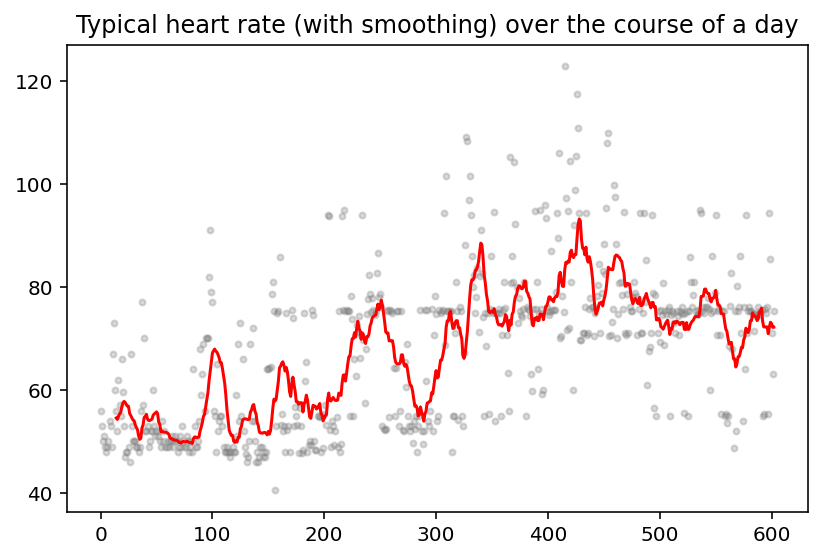

In [116]:
DATE_START = '2020-12-24 03:00:00'
DATE_END = '2020-12-24 15:00:00'

subset = df_hr_res[df_hr_res['aw_hr_start_time'].between(DATE_START, DATE_END)].set_index('aw_hr_start_time')

subset['avg'] = subset.rolling(15).mean()['aw_hr_heart_rate']

times = list(subset.reset_index()['aw_hr_start_time'].values)

plt.scatter(x=[i for i in range(len(times))], y=subset['aw_hr_heart_rate'], marker='.', color='grey', alpha=0.3)
plt.plot([i for i in range(len(times))], subset['avg'], color='red')
plt.xticks = times
plt.title('Typical heart rate (with smoothing) over the course of a day')
plt.tight_layout()
plt.savefig(FIGSDIR/'01b_example_hr_smoothing.png', dpi=500)
plt.show()

In [117]:
# Midnight unwrapping of date
df_aw_hr['aw_hr_date'] = df_aw_hr['aw_hr_start_time'].apply(datify)

In [118]:
def time_to_window(d):
    """Allocates a datetime to a time window.
    """
    
    def between(t, start, end):
        return True if pd.Timestamp(start).time() <= t <= pd.Timestamp(end).time() else False

    t = d.time()
    
    if between(t, '05:00:01', '11:00:00'):
        return 'morn'
    elif between(t, '11:00:01', '17:00:00'):
        return 'day'
    elif between(t, '17:00:01', '23:59:59'):
        return 'eve'
    elif between(t, '00:00:00', '05:00:00'):
        return 'night'
    else:
        return np.nan

In [119]:
# Applying time window allocation to HR data
df_aw_hr['aw_hr_window'] = df_aw_hr['aw_hr_start_time'].apply(time_to_window)

In [120]:
df_aw_hr.sample(5)

,aw_hr_start_time,aw_hr_heart_rate,aw_hr_date,aw_hr_window
1654,2020-01-12 09:43:00,79.000000,2020-01-12,morn
68492,2020-03-04 20:56:00,116.750000,2020-03-04,eve
434912,2020-12-19 02:31:00,70.400000,2020-12-18,night
445884,2020-12-27 13:08:00,75.400000,2020-12-27,day
154246,2020-05-11 14:12:00,78.333333,2020-05-11,day


In [121]:
# Aggregate HR by time windows for each day
df_aw_hr = df_aw_hr.groupby(['aw_hr_date', 'aw_hr_window']).agg(['median', 'std'])

# We collapse the multi-index and concatenate the names (beautiful!)
df_aw_hr.columns = df_aw_hr.columns.to_series().str.join('_')

# Pivot on time windows for each day to create 4 features
df_aw_hr = df_aw_hr.reset_index().pivot(
    index='aw_hr_date', columns='aw_hr_window', 
    values=['aw_hr_heart_rate_median', 'aw_hr_heart_rate_std']).reset_index()

# We collapse the multi-index and concatenate the names (beautiful!)
df_aw_hr.columns = df_aw_hr.columns.to_series().str.join('_')
df_aw_hr.sample(5).T

,203,264,315,44,5
aw_hr_date_,2020-07-31,2020-09-30,2020-11-20,2020-02-23,2020-01-15
aw_hr_heart_rate_median_day,75.6667,75.3068,78.0455,55,74.8
aw_hr_heart_rate_median_eve,75.6667,78.5,76,76,75.25
aw_hr_heart_rate_median_morn,55.625,55.25,70.3333,55.6,49
aw_hr_heart_rate_median_night,60.3333,55,50.3333,75.25,55
aw_hr_heart_rate_std_day,9.63179,8.91656,10.9448,11.8329,26.0305
aw_hr_heart_rate_std_eve,10.7284,14.797,13.383,13.4271,17.4045
aw_hr_heart_rate_std_morn,13.7372,11.5974,16.002,10.019,10.4772
aw_hr_heart_rate_std_night,9.693,12.2075,8.39463,9.31953,12.607


## Merging data

In [122]:
# Define the prefixes and variable names for all our dataframes
dfs = {
    'oura_summary_date': df_oura,
    'daily_date': df_daily,
    'hk_day': df_act,
    'nomie_alc_summary_date_': df_alc,
    'nomie_caf_summary_date_': df_caf,
    'rescue_date': df_rt,
    'cbd_summary_date': df_cbd,
    'melatonin_summary_date': df_mel,
    'zero_summary_date': df_zero,
    'wol_date': df_wol,
    'mood_date': df_mood,
    'aw_activ_date': df_aw_act,
    'aw_calls_date_': df_aw_call,
    'aw_loc_date_': df_aw_loc,
    'aw_weather_date': df_aw_weath,
    'aw_hr_date_': df_aw_hr,
}

In [123]:
# Verify the shape of each of the data frames with associated prefixes
for col, df in dfs.items():
    print(str(df.shape).ljust(10,' '), col, sep='\t')
    df[col] = pd.to_datetime(df[col])
    assert(col in df.columns)

(779, 87) 	oura_summary_date
(933, 45) 	daily_date
(929, 29) 	hk_day
(465, 6)  	nomie_alc_summary_date_
(595, 6)  	nomie_caf_summary_date_
(1401, 19)	rescue_date
(56, 6)   	cbd_summary_date
(135, 4)  	melatonin_summary_date
(608, 15) 	zero_summary_date
(707, 23) 	wol_date
(354, 4)  	mood_date
(378, 6)  	aw_activ_date
(219, 5)  	aw_calls_date_
(371, 18) 	aw_loc_date_
(367, 17) 	aw_weather_date
(381, 9)  	aw_hr_date_


In [124]:
# Start with a copy of the oura data (because sleep is what we care about)
df_unified = df_oura.copy()

# Loop through all the other dataframes and merge them (left join) based on the summary date
merge_col = 'oura_summary_date'
for col, df in dfs.items():
    if not df_unified.equals(df):
        print(f'Joining on {col}')
        df_unified = df_unified.merge(df, how='left', left_on=merge_col, right_on=col)
    prev_col = col

Joining on daily_date
Joining on hk_day
Joining on nomie_alc_summary_date_
Joining on nomie_caf_summary_date_
Joining on rescue_date
Joining on cbd_summary_date
Joining on melatonin_summary_date
Joining on zero_summary_date
Joining on wol_date
Joining on mood_date
Joining on aw_activ_date
Joining on aw_calls_date_
Joining on aw_loc_date_
Joining on aw_weather_date
Joining on aw_hr_date_


In [125]:
df_unified.shape

(789, 299)

In [127]:
# Detect all non-numerics (to see if we want to dummy them)
df_unified.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 789 entries, 0 to 788
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   oura_bedtime_end                789 non-null    object
 1   oura_bedtime_start              789 non-null    object
 2   oura_hr_5min                    789 non-null    object
 3   oura_hypnogram_5min             789 non-null    object
 4   oura_rmssd_5min                 789 non-null    object
 5   daily_current_location_(where_  478 non-null    object
 6   daily_notes                     185 non-null    object
 7   daily_some_factor_changed       116 non-null    object
 8   location                        784 non-null    object
 9   city                            459 non-null    object
 10  country                         686 non-null    object
 11  zero_end                        481 non-null    object
 12  zero_end_time                   481 non-null    ob

We can convert our categorical-like columns into "dummies" (i.e. make sparse vectors). This gives us more numeric features to train on.

In [128]:
df_unified = pd.concat([df_unified, pd.get_dummies(df_unified[['location', 'city', 'country']])], axis=1)

Now we'll save the joined dataset as a csv

In [129]:
df_unified.shape

(789, 309)

In [130]:
# Export to CSV file
df_unified.to_csv(DATADIR/'Unified'/'unified_dataset.csv', index=None)